# Лабораторная работа № 1
## Выполнение разведочного анализа больших данных с использованием фреймворка Apache Spark

## Часть 1
В данной части работы рассмотрены:

* разведочный анализ данных;
* работа с Dataframe API фреймворка `Apache Spark`.

Подключаем необходимые библиотеки.

In [1]:
import os
from pyspark.sql import SparkSession, DataFrame
from pyspark import SparkConf
from pyspark.sql.window import Window
from pyspark.sql.functions import (
    col, lit, sum, mean, when,
    explode, count, desc, floor,
    corr, array_contains, first,
    year, month, dayofmonth, length,
    from_unixtime, row_number, countDistinct,
    stddev, min, max, to_date, date_format, lower
)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.dates as mdates

### Общие функции

In [2]:
def create_spark_configuration() -> SparkConf:
    """
    Создает и конфигурирует экземпляр SparkConf для приложения Spark.
    """
    conf = SparkConf()
    conf.setAppName("lab 1 Movies EDA")
    conf.setMaster("local[*]")
    conf.set("spark.sql.adaptive.enabled", "true")
    conf.set("spark.executor.memory", "12g")
    conf.set("spark.executor.cores", "6")
    conf.set("spark.executor.instances", "1")
    conf.set("spark.driver.memory", "7g")
    conf.set("spark.driver.cores", "1")
    conf.set("spark.hadoop.fs.defaultFS", "hdfs://hadoop-namenode:9820")
    conf.set("spark.hadoop.dfs.client.use.datanode.hostname", "true")
    conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")
    return conf

In [3]:
def analyze_missing_values(data: DataFrame) -> None:
    print("=== АНАЛИЗ ПРОПУЩЕННЫХ ЗНАЧЕНИЙ ===")
    
    total_count = data.count()
    for column in data.columns:
        null_count = data.filter(col(column).isNull()).count()
        null_percentage = (null_count / total_count) * 100
        print(f"{column}: {null_count} пропусков ({null_percentage:.2f}%)")

In [4]:
def handle_null_values(data: DataFrame) -> DataFrame:
    print("=== ОБРАБОТКА NULL ЗНАЧЕНИЙ ===")
    
    # Заменяем NULL в строковых полях на 'Unknown'
    string_columns = [f.name for f in data.schema.fields 
                     if f.dataType.simpleString() in ['string', 'varchar']]
    
    cleaned_data = data
    for column in string_columns:
        null_count = cleaned_data.filter(col(column).isNull()).count()
        if null_count > 0:
            cleaned_data = cleaned_data.fillna({column: "Unknown"})
            print(f"Заменено NULL в {column}: {null_count} значений")
    
    # Преобразуем unixReviewTime в reviewTime если reviewTime NULL
    null_reviewtime_count = cleaned_data.filter(
        col("reviewTime").isNull() & col("unixReviewTime").isNotNull()
    ).count()
    
    if null_reviewtime_count > 0:
        cleaned_data = cleaned_data.withColumn(
            "reviewTime",
            when(
                col("reviewTime").isNull() & col("unixReviewTime").isNotNull(),
                from_unixtime(col("unixReviewTime"), "yyyy-MM-dd")
            ).otherwise(col("reviewTime"))
        )
        print(f"Преобразовано unixReviewTime в reviewTime: {null_reviewtime_count} значений")
    
    print("=== ОБРАБОТКА NULL ЗАВЕРШЕНА ===\n")
    return cleaned_data

In [5]:
def analyze_problematic_data(data: DataFrame) -> None:
    print("=== АНАЛИЗ ПРОБЛЕМНЫХ ДАННЫХ ===")
    
    # Проблемные ASIN
    problematic_asin = data.filter(
        ~col("asin").rlike(r"^[A-Z0-9]{10}$") | 
        (length(col("asin")) != 10)
    ).select("asin").distinct()
    
    print("Примеры проблемных ASIN:")
    problematic_asin_collected = problematic_asin.collect()
    for row in problematic_asin_collected[:10]:
        print(f"  {row['asin']}")
    
    # Проблемные reviewerID
    problematic_reviewerid = data.filter(
        col("reviewerID").isNull() | 
        ~col("reviewerID").rlike(r"^[A-Z0-9]{1,50}$")
    ).select("reviewerID").distinct()
    
    print("Примеры проблемных reviewerID:")
    problematic_reviewerid_collected = problematic_reviewerid.collect()
    for row in problematic_reviewerid_collected[:10]:
        print(f"  {row['reviewerID']}")
    
    # Проблемные оценки
    problematic_ratings = data.filter(
        col("overall").isNull() | 
        ~col("overall").between(1.0, 5.0)
    ).select("overall").distinct()
    
    print("Проблемные оценки:")
    problematic_ratings_collected = problematic_ratings.collect()
    for row in problematic_ratings_collected[:10]:
        print(f"  {row['overall']}")
    
    # Проблемные timestamp
    problematic_timestamp = data.filter(
        col("unixReviewTime").isNull() | 
        ~col("unixReviewTime").rlike(r"^[0-9]{1,15}$") |
        (col("unixReviewTime") < 946684800)  # До 2000 года
    ).select("unixReviewTime").distinct()
    
    print("Проблемные unixReviewTime:")
    problematic_timestamp_collected = problematic_timestamp.collect()
    for row in problematic_timestamp_collected[:10]:
        print(f"  {row['unixReviewTime']}")
    
    # Проблемные reviewTime (после преобразования)
    problematic_reviewtime = data.filter(
        col("reviewTime").isNull()
    ).count()
    
    print(f"Оставшиеся NULL в reviewTime: {problematic_reviewtime}")

### Функции очистки данных

In [6]:
def clean_data_by_patterns(data: DataFrame) -> DataFrame:
    print("=== НАЧАЛО ОЧИСТКИ ДАННЫХ ПО ШАБЛОНАМ ===")
    
    initial_count = data.count()
    print(f"Начальное количество строк: {initial_count}")
    
    # Шаблоны для каждого столбца
    patterns = {
        "asin": r"^[A-Z0-9]{10}$",  # ASIN обычно 10 символов (буквы и цифры)
        "reviewerID": r"^[A-Z0-9]{1,50}$",  # ID рецензента (только буквы и цифры)
        "reviewerName": r"^[a-zA-Z0-9\s\.\-]{1,100}$",  # Имя (буквы, цифры, пробелы, точки, дефисы)
        "overall": r"^[1-5](\\.0)?$",  # Оценка от 1.0 до 5.0
        "unixReviewTime": r"^[0-9]{1,15}$",  # Unix timestamp (только цифры)
    }
    
    # Применяем фильтры для каждого столбца
    cleaned_data = data
    
    # ASIN - должен быть 10 символов, только буквы и цифры
    cleaned_data = cleaned_data.filter(
        col("asin").rlike(patterns["asin"]) & 
        (length(col("asin")) == 10)
    )
    print(f"После фильтрации ASIN: {cleaned_data.count()} строк")
    
    # reviewerID - не NULL и соответствует шаблону
    cleaned_data = cleaned_data.filter(
        col("reviewerID").isNotNull() & 
        col("reviewerID").rlike(patterns["reviewerID"])
    )
    print(f"После фильтрации reviewerID: {cleaned_data.count()} строк")
    
    # reviewerName - может быть NULL, но если есть - должен соответствовать шаблону
    cleaned_data = cleaned_data.filter(
        col("reviewerName").isNull() | 
        col("reviewerName").rlike(patterns["reviewerName"])
    )
    print(f"После фильтрации reviewerName: {cleaned_data.count()} строк")
    
    # overall - оценка от 1.0 до 5.0
    cleaned_data = cleaned_data.filter(
        col("overall").isNotNull() & 
        col("overall").between(1.0, 5.0)
    )
    print(f"После фильтрации overall: {cleaned_data.count()} строк")
    
    # unixReviewTime - должен быть числом и разумным timestamp (после 2000 года)
    cleaned_data = cleaned_data.filter(
        col("unixReviewTime").isNotNull() & 
        col("unixReviewTime").rlike(patterns["unixReviewTime"]) &
        (col("unixReviewTime") >= 946684800)  # 2000-01-01
    )
    print(f"После фильтрации unixReviewTime: {cleaned_data.count()} строк")
    
    # reviewText - если не NULL, то не должен быть слишком коротким (минимум 10 символов)
    cleaned_data = cleaned_data.filter(
        col("reviewText").isNull() | 
        (length(col("reviewText")) >= 10)
    )
    print(f"После фильтрации reviewText: {cleaned_data.count()} строк")
    
    final_count = cleaned_data.count()
    removed_count = initial_count - final_count
    print(f"Удалено строк: {removed_count} ({removed_count/initial_count*100:.2f}%)")
    print(f"Финальное количество строк: {final_count}")
    print("=== ОЧИСТКА ДАННЫХ ЗАВЕРШЕНА ===\n")
    
    return cleaned_data

In [7]:
def analyze_duplicates(data: DataFrame) -> None:
    """
    Анализирует дубликаты в данных.
    """
    print("=== АНАЛИЗ ДУБЛИКАТОВ ===")
    
    # Дубликаты по полному набору полей
    full_duplicates = data.groupBy(data.columns).count().filter(col("count") > 1)
    print(f"Полные дубликаты: {full_duplicates.count()}")
    
    # Дубликаты по reviewerID + asin + unixReviewTime
    review_duplicates = data.groupBy("reviewerID", "asin", "unixReviewTime").count().filter(col("count") > 1)
    print(f"Дубликаты отзывов (reviewerID + asin + unixReviewTime): {review_duplicates.count()}")
    
    if review_duplicates.count() > 0:
        print("Примеры дубликатов отзывов:")
        review_duplicates_collected = review_duplicates.collect()
        for row in review_duplicates_collected[:5]:
            print(f"  reviewerID: {row['reviewerID']}, asin: {row['asin']}, count: {row['count']}")


In [8]:
def remove_duplicates(data: DataFrame) -> DataFrame:
    """
    Удаляет дубликаты из данных.
    """
    print("=== УДАЛЕНИЕ ДУБЛИКАТОВ ===")
    
    initial_count = data.count()
    
    # Удаляем полные дубликаты
    cleaned_data = data.dropDuplicates()
    
    # Для дубликатов по reviewerID + asin + unixReviewTime 
    window_spec = Window.partitionBy("reviewerID", "asin", "unixReviewTime").orderBy("unixReviewTime")
    cleaned_data = cleaned_data.withColumn("row_num", row_number().over(window_spec))
    cleaned_data = cleaned_data.filter(col("row_num") == 1).drop("row_num")
    
    final_count = cleaned_data.count()
    removed_count = initial_count - final_count
    
    print(f"Удалено дубликатов: {removed_count}")
    print(f"Финальное количество строк: {final_count}")
    
    return cleaned_data

### Создание Spark сессии и загрузка данных

In [9]:
# Создаём сам объект конфигурации.
conf = create_spark_configuration()

# Создаём и выводим на экран сессию `Apache Spark.`
spark = SparkSession.builder.config(conf=conf).getOrCreate()
spark

# Укажем базу данных, которая была создана в первой части лабораторной работы.
df = spark.read.parquet("hdfs://hadoop-namenode:9820/data/mattiev_database/movies_lab1_parquet_table")

# Выведем данные, которые были получены ранее.
df.show(10)
df.printSchema()

+--------------------+--------------+--------------------+--------------------+-------+--------------------+--------------+----------+
|                asin|    reviewerID|        reviewerName|          reviewText|overall|             summary|unixReviewTime|reviewTime|
+--------------------+--------------+--------------------+--------------------+-------+--------------------+--------------+----------+
| Not so good: the...|          NULL|                NULL| it's scope was c...|   NULL|                NULL|          NULL|      NULL|
|             Alright|          NULL|                NULL|                NULL|   NULL|                NULL|          NULL|      NULL|
|3 1/2 stars round...|          NULL|                NULL|         trashcanman|   NULL|                   4|          NULL|      NULL|
|          B0029Z8KK6| AYJVVATZH32YP|                 pj1|it is very nice t...|    5.0|          Five Stars|    1523577600|      NULL|
|          B0029Z8KK6|A2GHRRRM85HYX0|          Zach Sat

### Анализ данных

In [21]:
# Выполним функцию анализа пропущенных значений.
analyze_missing_values(df)

# Анализируем исходные проблемные данные
analyze_problematic_data(df)

=== АНАЛИЗ ПРОПУЩЕННЫХ ЗНАЧЕНИЙ ===
asin: 265 пропусков (0.00%)
reviewerID: 4034232 пропусков (30.51%)
reviewerName: 4642944 пропусков (35.11%)
reviewText: 2192918 пропусков (16.58%)
overall: 4459472 пропусков (33.72%)
summary: 4948349 пропусков (37.42%)
unixReviewTime: 5750734 пропусков (43.49%)
reviewTime: 10315311 пропусков (78.01%)
=== АНАЛИЗ ПРОБЛЕМНЫХ ДАННЫХ ===
Примеры проблемных ASIN:
  I wish my French were better.  I'd probably like this film better."
  To be fair the cast tried to sell the story. The writing was good in places and a few decent splashes of directing popped up in some of the lighting and cinematography.  However
  The dvd is packed with 23 tremendous songs
  1. New York Minute  13:31  (orig.: The Eagles)
  ""Vacation Massacre"" is yet another in the long thread of (Italian) films that mimic the 1972 US exploitation hit ""Last House on the Left"".  Technically the film is obviously very low budget-nearly amateurish
  If you don't have any trouble laughing at jo

### Обработка и очистка 

In [10]:
# Обрабатываем NULL значения
df_step1 = handle_null_values(df)
print("После обработки NULL:")
df_step1.show(5)

# Очищаем данные по шаблонам
df_step2 = clean_data_by_patterns(df_step1)

# Анализируем дубликаты
analyze_duplicates(df_step2)

# Удаляем дубликаты
df_final = remove_duplicates(df_step2)

# Выводим финальный результат
print("=== ФИНАЛЬНЫЙ РЕЗУЛЬТАТ ОЧИСТКИ ===")
print("Пример корректных данных:")
df_final.show(10)

print("\nСхема данных:")
df_final.printSchema()

print(f"\nФинальное количество строк: {df_final.count()}")

# Проверяем что нет NULL в ключевых полях
print("=== ПРОВЕРКА КАЧЕСТВА ДАННЫХ ПОСЛЕ ОЧИСТКИ ===")

# Проверяем NULL в ключевых полях
key_columns = ["asin", "reviewerID", "overall", "unixReviewTime"]
for column in key_columns:
    null_count = df_final.filter(col(column).isNull()).count()
    print(f"NULL в {column}: {null_count}")

# Проверяем reviewTime (должно быть мало NULL после преобразования)
reviewtime_null = df_final.filter(col("reviewTime").isNull()).count()
print(f"NULL в reviewTime: {reviewtime_null}")

# Проверяем reviewerName (должно быть 'Unknown' вместо NULL)
reviewername_unknown = df_final.filter(col("reviewerName") == "Unknown").count()
print(f"reviewerName = 'Unknown': {reviewername_unknown}")

=== ОБРАБОТКА NULL ЗНАЧЕНИЙ ===
Заменено NULL в asin: 265 значений
Заменено NULL в reviewerID: 4034232 значений
Заменено NULL в reviewerName: 4642944 значений
Заменено NULL в reviewText: 2192918 значений
Заменено NULL в summary: 4948349 значений
Преобразовано unixReviewTime в reviewTime: 4565695 значений
=== ОБРАБОТКА NULL ЗАВЕРШЕНА ===

После обработки NULL:
+--------------------+--------------+------------+--------------------+-------+----------+--------------+----------+
|                asin|    reviewerID|reviewerName|          reviewText|overall|   summary|unixReviewTime|reviewTime|
+--------------------+--------------+------------+--------------------+-------+----------+--------------+----------+
| Not so good: the...|       Unknown|     Unknown| it's scope was c...|   NULL|   Unknown|          NULL|      NULL|
|             Alright|       Unknown|     Unknown|             Unknown|   NULL|   Unknown|          NULL|      NULL|
|3 1/2 stars round...|       Unknown|     Unknown|   

### Анализ столбца Asin (первичный ключ)

In [25]:
### Анализ столбца `Asin` (первичный ключ)

print("=== АНАЛИЗ СТОЛБЦА ASIN ===")
print("ASIN - уникальный идентификатор продукта (первичный ключ)\n")

# 1. Проверка уникальности
print("1. ПРОВЕРКА УНИКАЛЬНОСТИ:")
asin_unique_count = df_final.select("asin").distinct().count()
total_rows = df_final.count()
print(f"Уникальных ASIN: {asin_unique_count}")
print(f"Всего строк: {total_rows}")
print(f"Соотношение: {asin_unique_count/total_rows*100:.2f}%\n")

# 2. Проверка дубликатов
print("2. ПРОВЕРКА ДУБЛИКАТОВ ASIN:")
asin_duplicates = df_final.groupBy("asin").count().filter(col("count") > 1)
duplicate_count = asin_duplicates.count()
print(f"Количество ASIN с дубликатами: {duplicate_count}")

if duplicate_count > 0:
    print("Примеры дублирующихся ASIN:")
    asin_duplicates.orderBy(desc("count")).limit(10).show()
    
    # Посмотрим на сами дублирующиеся записи
    sample_duplicate_asin = asin_duplicates.limit(1).collect()[0]["asin"]
    print(f"\nПример записей с дублирующимся ASIN '{sample_duplicate_asin}':")
    df_final.filter(col("asin") == sample_duplicate_asin).show(5)

# 3. Проверка формата и длины
print("\n3. ПРОВЕРКА ФОРМАТА И ДЛИНЫ:")
print("Статистика по длине ASIN:")
length_stats = df_final.select(length("asin").alias("asin_length")).groupBy("asin_length").count().orderBy("asin_length").collect()
for row in length_stats:
    print(f"  Длина {row['asin_length']}: {row['count']} записей")

# 4. Проверка на NULL значения
print("\n4. ПРОВЕРКА NULL ЗНАЧЕНИЙ:")
asin_null_count = df_final.filter(col("asin").isNull()).count()
print(f"NULL значений в ASIN: {asin_null_count}")

# 5. Примеры значений
print("\n5. ПРИМЕРЫ ЗНАЧЕНИЙ ASIN:")
print("Первые 10 уникальных ASIN:")
unique_asin_collected = df_final.select("asin").distinct().collect()
for row in unique_asin_collected[:10]:
    print(f"  {row['asin']}")

# 6. Проверка шаблона (только буквы и цифры)
print("\n6. ПРОВЕРКА ШАБЛОНА (только A-Z, 0-9):")
invalid_asin_pattern = df_final.filter(~col("asin").rlike("^[A-Z0-9]+$"))
print(f"ASIN с некорректными символами: {invalid_asin_pattern.count()}")



=== АНАЛИЗ СТОЛБЦА ASIN ===
ASIN - уникальный идентификатор продукта (первичный ключ)

1. ПРОВЕРКА УНИКАЛЬНОСТИ:
Уникальных ASIN: 161908
Всего строк: 6439543
Соотношение: 2.51%

2. ПРОВЕРКА ДУБЛИКАТОВ ASIN:
Количество ASIN с дубликатами: 116548
Примеры дублирующихся ASIN:
+----------+-----+
|      asin|count|
+----------+-----+
|B00YSG2ZPA|20359|
|B00006CXSS|20300|
|B01BHTSIOC|18413|
|B00AQVMZKQ|17903|
|B00NAQ3EOK|14585|
|6305837325|13626|
|B017S3OP7A|12647|
|B00WNBABVC|12211|
|B014HDTT84|12152|
|B00OGL6S64|12085|
+----------+-----+


Пример записей с дублирующимся ASIN 'B00020X83Y':
+----------+--------------+---------------+--------------------+-------+--------------------+--------------+----------+
|      asin|    reviewerID|   reviewerName|          reviewText|overall|             summary|unixReviewTime|reviewTime|
+----------+--------------+---------------+--------------------+-------+--------------------+--------------+----------+
|B00020X83Y|A104EFOU8X4II5|Amazon Customer|Good p

### Анализ столбца `reviewerID`

In [26]:
### Анализ столбца `reviewerID`

print("=== АНАЛИЗ СТОЛБЦА REVIEWERID ===")
print("reviewerID - уникальный идентификатор рецензента\n")

# 1. Проверка уникальности
print("1. ПРОВЕРКА УНИКАЛЬНОСТИ:")
reviewer_unique_count = df_final.select("reviewerID").distinct().count()
total_rows = df_final.count()
print(f"Уникальных reviewerID: {reviewer_unique_count}")
print(f"Всего строк: {total_rows}")
print(f"Соотношение: {reviewer_unique_count/total_rows*100:.2f}%\n")

# 2. Проверка дубликатов (по reviewerID + asin)
print("2. ПРОВЕРКА ДУБЛИКАТОВ ОТЗЫВОВ:")
review_duplicates = df_final.groupBy("reviewerID", "asin").count().filter(col("count") > 1)
duplicate_review_count = review_duplicates.count()
print(f"Количество дублирующихся отзывов (один рецензент на один продукт): {duplicate_review_count}")

if duplicate_review_count > 0:
    print("Примеры дублирующихся отзывов:")
    review_duplicates.orderBy(desc("count")).limit(5).show()
    
    # Посмотрим на сами дублирующиеся записи
    sample_duplicate = review_duplicates.limit(1).collect()[0]
    print(f"\nПример записей где reviewerID '{sample_duplicate['reviewerID']}' оставил multiple отзывы на ASIN '{sample_duplicate['asin']}':")
    df_final.filter(
        (col("reviewerID") == sample_duplicate["reviewerID"]) & 
        (col("asin") == sample_duplicate["asin"])
    ).show(5)

# 3. Активность рецензентов
print("\n3. АНАЛИЗ АКТИВНОСТИ РЕЦЕНЗЕНТОВ:")
reviewer_activity = df_final.groupBy("reviewerID").agg(
    count("*").alias("review_count"),
    mean("overall").alias("avg_rating"),
    countDistinct("asin").alias("unique_products")
)

print("Статистика по активности рецензентов:")
activity_stats = reviewer_activity.select(
    "review_count", "avg_rating", "unique_products"
).describe().collect()

# Собираем статистику
stats_dict = {}
for row in activity_stats:
    stat_name = row['summary']
    stats_dict[stat_name] = {
        'review_count': row['review_count'],
        'avg_rating': row['avg_rating'],
        'unique_products': row['unique_products']
    }

for stat in ['count', 'mean', 'stddev', 'min', 'max']:
    if stat in stats_dict:
        data = stats_dict[stat]
        print(f"  {stat}: reviews={data['review_count']}, avg_rating={data['avg_rating']}, unique_products={data['unique_products']}")

# 4. Топ самых активных рецензентов
print("\n4. ТОП-10 САМЫХ АКТИВНЫХ РЕЦЕНЗЕНТОВ:")
top_reviewers_collected = reviewer_activity.orderBy(desc("review_count")).collect()
print("ReviewerID | Количество отзывов | Средняя оценка | Уникальных продуктов")
print("-" * 80)
for row in top_reviewers_collected[:10]:
    print(f"{row['reviewerID']} | {row['review_count']} | {row['avg_rating']:.2f} | {row['unique_products']}")

# 5. Проверка на NULL значения
print("\n5. ПРОВЕРКА NULL ЗНАЧЕНИЙ:")
reviewerid_null_count = df_final.filter(col("reviewerID").isNull()).count()
print(f"NULL значений в reviewerID: {reviewerid_null_count}")

# 6. Проверка формата
print("\n6. ПРОВЕРКА ФОРМАТА И ДЛИНЫ:")
print("Статистика по длине reviewerID:")
reviewerid_length_stats = df_final.select(length("reviewerID").alias("reviewerID_length")).groupBy("reviewerID_length").count().orderBy("reviewerID_length").collect()
for row in reviewerid_length_stats[:10]:
    print(f"  Длина {row['reviewerID_length']}: {row['count']} записей")

# 7. Примеры значений
print("\n7. ПРИМЕРЫ ЗНАЧЕНИЙ REVIEWERID:")
print("Первые 10 уникальных reviewerID:")
unique_reviewerid_collected = df_final.select("reviewerID").distinct().collect()
for row in unique_reviewerid_collected[:10]:
    print(f"  {row['reviewerID']}")

=== АНАЛИЗ СТОЛБЦА REVIEWERID ===
reviewerID - уникальный идентификатор рецензента

1. ПРОВЕРКА УНИКАЛЬНОСТИ:
Уникальных reviewerID: 3210466
Всего строк: 6439543
Соотношение: 49.86%

2. ПРОВЕРКА ДУБЛИКАТОВ ОТЗЫВОВ:
Количество дублирующихся отзывов (один рецензент на один продукт): 3617
Примеры дублирующихся отзывов:
+--------------+----------+-----+
|    reviewerID|      asin|count|
+--------------+----------+-----+
| AOV0G8H22RNFH|B000BOH98G|   10|
|A1HFVR8HIO0R22|6304404859|    9|
|A2IMP5N1CT9M80|0792146433|    9|
|A2IMP5N1CT9M80|630413231X|    9|
| AW3VZ5O895LRK|B002LITRJ4|    8|
+--------------+----------+-----+


Пример записей где reviewerID 'A22Q7VV18FH2R1' оставил multiple отзывы на ASIN '5819906179':
+----------+--------------+------------+--------------------+-------+--------------------+--------------+----------+
|      asin|    reviewerID|reviewerName|          reviewText|overall|             summary|unixReviewTime|reviewTime|
+----------+--------------+------------+-------

### Анализ столбца `reviewerName` 

=== АНАЛИЗ СТОЛБЦА REVIEWERNAME ===
reviewerName - имя рецензента (категориальный признак)

1. ПРОВЕРКА УНИКАЛЬНОСТИ:
Уникальных имен: 1994739
Соотношение уникальных имен к общему количеству: 30.98%

2. ПРОВЕРКА NULL И 'UNKNOWN' ЗНАЧЕНИЙ:
NULL значений: 0
Значений 'Unknown': 593
Процент 'Unknown': 0.01%

3. ТОП-20 САМЫХ ПОПУЛЯРНЫХ ИМЕН:
Имя | Количество
----------------------------------------
Amazon Customer | 409566
Kindle Customer | 42638
John | 6099
Mike | 5792
David | 5313
Chris | 5307
Michael | 5161
Linda | 3695
Pen Name | 3628
Mark | 3585
James | 3570
Mary | 3508
Steve | 3469
Robert | 3417
Jennifer | 3349
Lisa | 3254
Brian | 3140
Sarah | 3119
Jim | 3051
Bill | 2976

4. ВИЗУАЛИЗАЦИЯ ТОП ИМЕН:


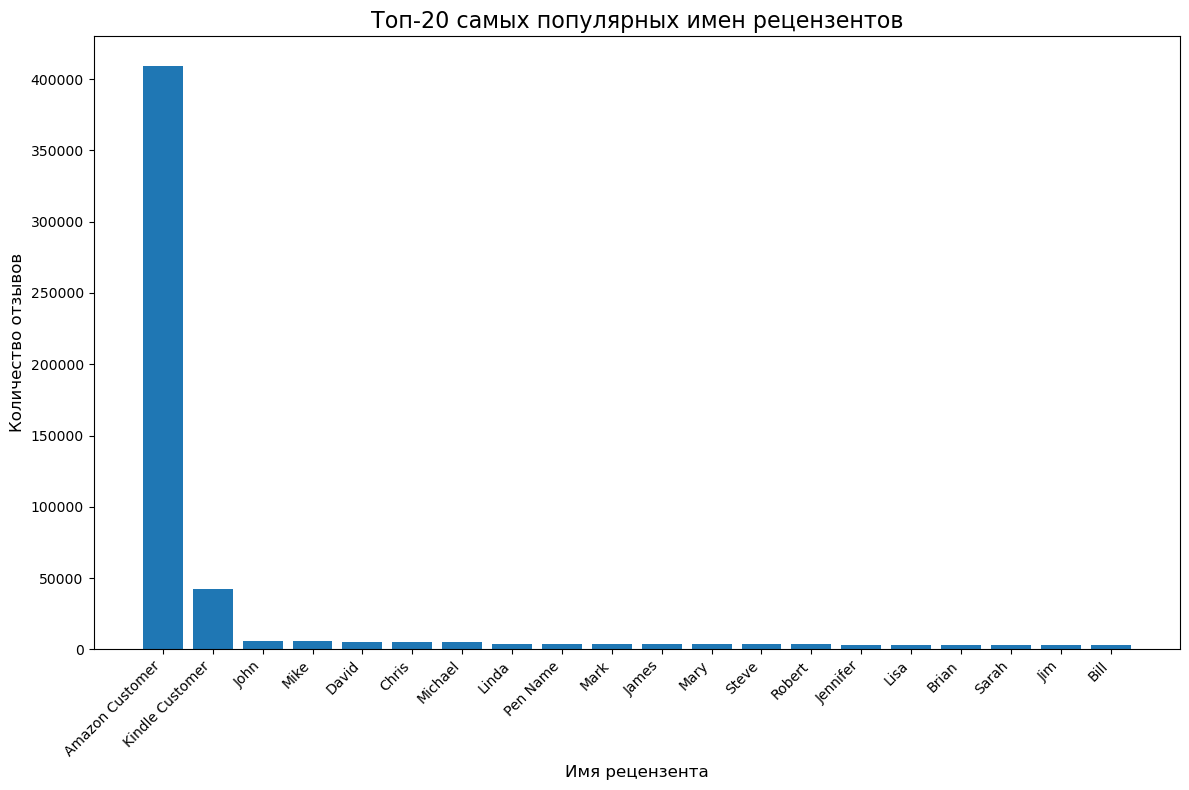


5. АНАЛИЗ ДЛИНЫ ИМЕН:
  count: 6439543
  mean: 10.591030450452774
  stddev: 4.635204411419565
  min: 1
  max: 100

6. РАСПРЕДЕЛЕНИЕ ДЛИНЫ ИМЕН:


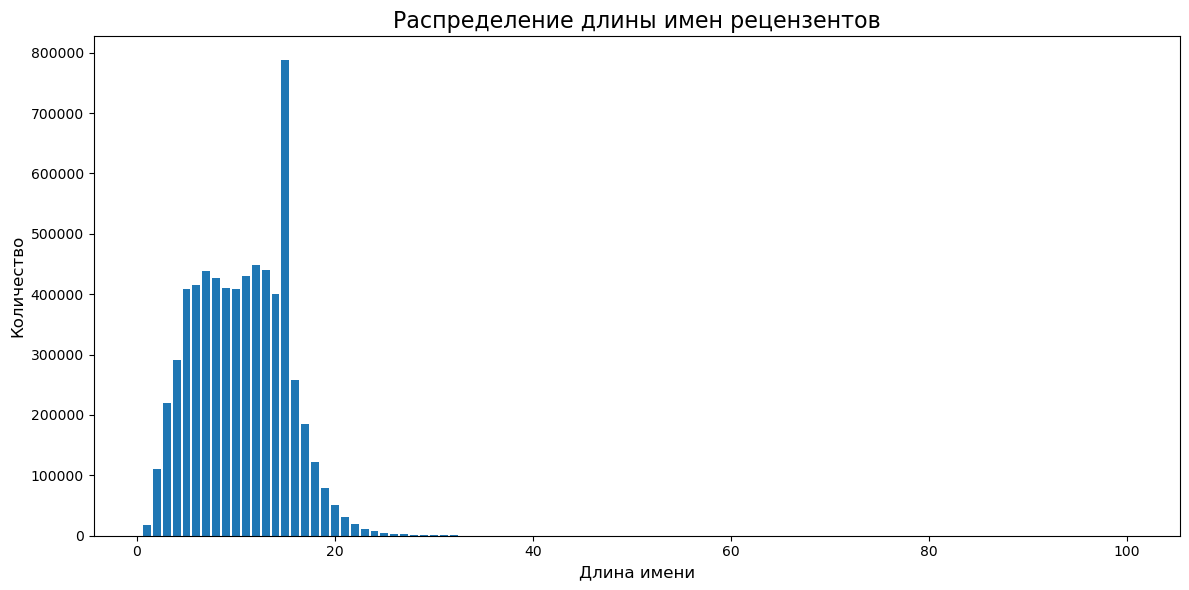

In [27]:
### Анализ столбца `reviewerName` 

print("=== АНАЛИЗ СТОЛБЦА REVIEWERNAME ===")
print("reviewerName - имя рецензента \n")

# 1. Проверка уникальности
print("1. ПРОВЕРКА УНИКАЛЬНОСТИ:")
reviewer_name_unique_count = df_final.select("reviewerName").distinct().count()
print(f"Уникальных имен: {reviewer_name_unique_count}")
print(f"Соотношение уникальных имен к общему количеству: {reviewer_name_unique_count/total_rows*100:.2f}%\n")

# 2. Проверка NULL и 'UNKNOWN' значений
print("2. ПРОВЕРКА NULL И 'UNKNOWN' ЗНАЧЕНИЙ:")
reviewername_null_count = df_final.filter(col("reviewerName").isNull()).count()
reviewername_unknown_count = df_final.filter(col("reviewerName") == "Unknown").count()
print(f"NULL значений: {reviewername_null_count}")
print(f"Значений 'Unknown': {reviewername_unknown_count}")
print(f"Процент 'Unknown': {reviewername_unknown_count/total_rows*100:.2f}%\n")

# 3. Топ-20 самых популярных имен
print("3. ТОП-20 САМЫХ ПОПУЛЯРНЫХ ИМЕН:")
top_names_collected = df_final.groupBy("reviewerName").count().orderBy(desc("count")).collect()
print("Имя | Количество")
print("-" * 40)
for row in top_names_collected[:20]:
    print(f"{row['reviewerName']} | {row['count']}")

# 4. Визуализация топ имен
print("\n4. ВИЗУАЛИЗАЦИЯ ТОП ИМЕН:")
top_names_for_plot = [(row['reviewerName'], row['count']) for row in top_names_collected[:20]]
names, counts = zip(*top_names_for_plot)

plt.figure(figsize=(12, 8))
plt.bar(names, counts)
plt.title('Топ-20 самых популярных имен рецензентов', fontsize=16)
plt.xlabel('Имя рецензента', fontsize=12)
plt.ylabel('Количество отзывов', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 5. Анализ длины имен
print("\n5. АНАЛИЗ ДЛИНЫ ИМЕН:")
name_length_stats = df_final.select(length("reviewerName").alias("name_length")).describe().collect()
for row in name_length_stats:
    print(f"  {row['summary']}: {row['name_length']}")

# 6. Распределение длины имен
print("\n6. РАСПРЕДЕЛЕНИЕ ДЛИНЫ ИМЕН:")
name_length_distribution = df_final.select(length("reviewerName").alias("name_length")).groupBy("name_length").count().orderBy("name_length").collect()

plt.figure(figsize=(12, 6))
lengths = [row['name_length'] for row in name_length_distribution]
counts = [row['count'] for row in name_length_distribution]
plt.bar(lengths, counts)
plt.title('Распределение длины имен рецензентов', fontsize=16)
plt.xlabel('Длина имени', fontsize=12)
plt.ylabel('Количество', fontsize=12)
plt.tight_layout()
plt.show()

### Анализ столбца `overall` (количественный признак - рейтинг)

=== АНАЛИЗ СТОЛБЦА OVERALL ====
overall - оценка продукта от 1.0 до 5.0

1. СТАТИСТИКА ПО ОЦЕНКАМ:
Метрика | Значение
-------------------------
count | 6439543
mean | 4.2756305843442615
stddev | 1.2005766460497826
min | 1.0
max | 5.0

2. РАСПРЕДЕЛЕНИЕ ОЦЕНОК:
Оценка | Количество | Процент
-----------------------------------
1.0 | 446126 | 6.93%
2.0 | 274155 | 4.26%
3.0 | 498852 | 7.75%
4.0 | 1059935 | 16.46%
5.0 | 4160475 | 64.61%

3. ВИЗУАЛИЗАЦИЯ РАСПРЕДЕЛЕНИЯ ОЦЕНОК:


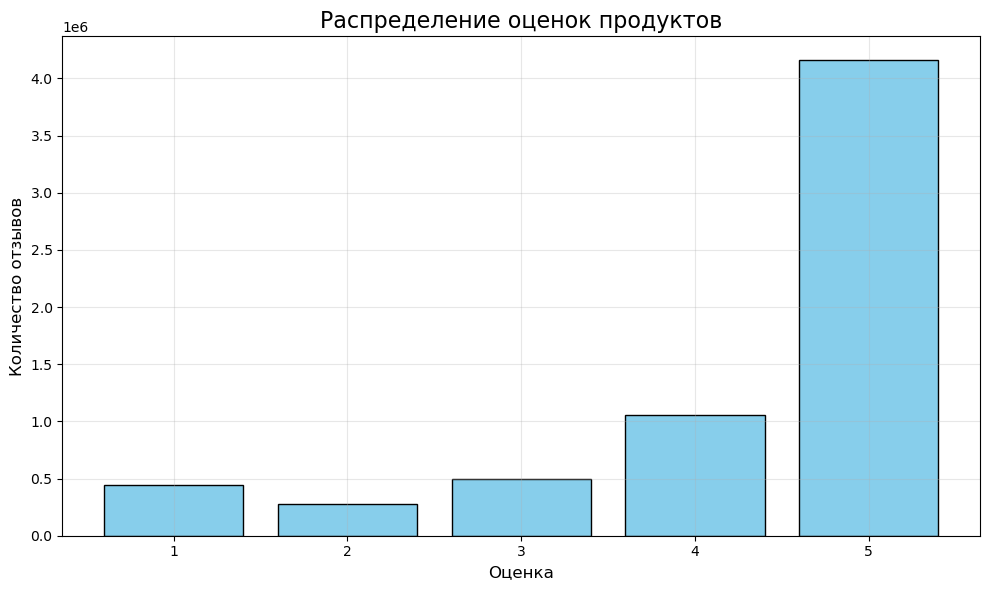


4. САМЫЕ ПОПУЛЯРНЫЕ ОЦЕНКИ:
Оценка | Количество | Ранг
------------------------------
5.0 | 4160475 | 1
4.0 | 1059935 | 2
3.0 | 498852 | 3
1.0 | 446126 | 4
2.0 | 274155 | 5

5. АНАЛИЗ ПОЛОЖИТЕЛЬНЫХ И ОТРИЦАТЕЛЬНЫХ ОЦЕНОК:
Положительные оценки (4.0-5.0): 5220410 (81.07%)
Нейтральные оценки (2.1-3.9): 498852 (7.75%)
Отрицательные оценки (1.0-2.0): 720281 (11.19%)


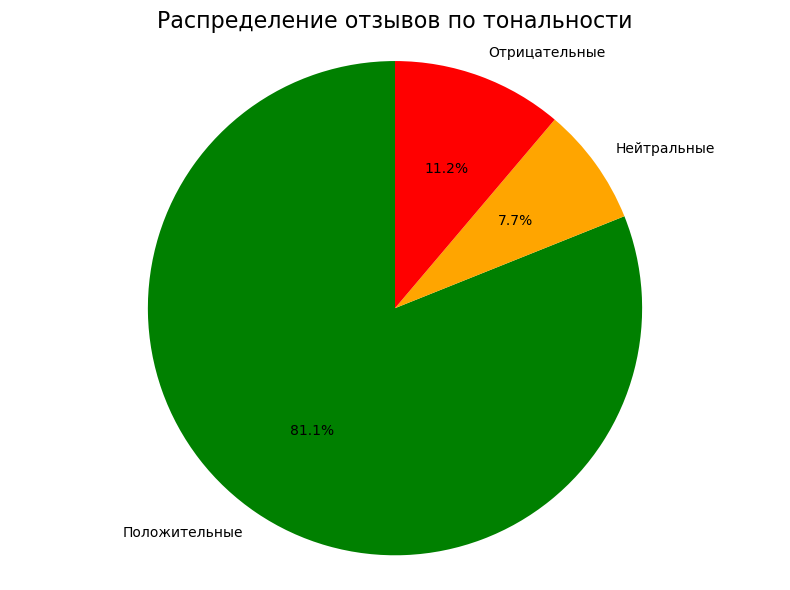


6. ДИНАМИКА СРЕДНИХ ОЦЕНОК ПО ВРЕМЕНИ:


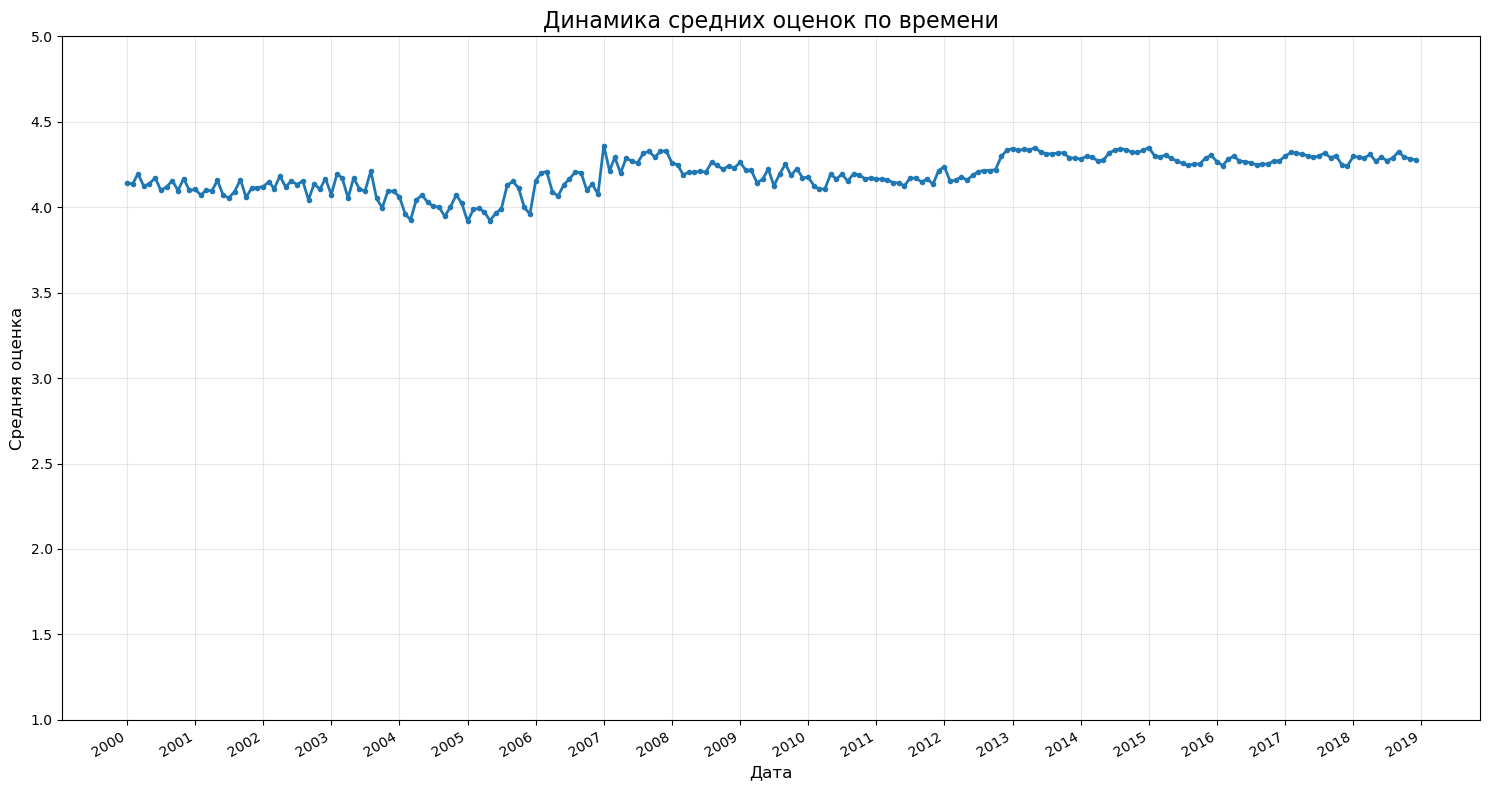

In [13]:
### Анализ столбца `overall` (оценки)

print("=== АНАЛИЗ СТОЛБЦА OVERALL ====")
print("overall - оценка продукта от 1.0 до 5.0\n")

# 1. Статистика по оценкам
print("1. СТАТИСТИКА ПО ОЦЕНКАМ:")
overall_stats = df_final.select("overall").describe().collect()
print("Метрика | Значение")
print("-" * 25)
for row in overall_stats:
    print(f"{row['summary']} | {row['overall']}")

# 2. Распределение оценок
print("\n2. РАСПРЕДЕЛЕНИЕ ОЦЕНОК:")
ratings_distribution = df_final.groupBy("overall").count().orderBy("overall").collect()
print("Оценка | Количество | Процент")
print("-" * 35)
total_ratings = df_final.count()
for row in ratings_distribution:
    percentage = (row['count'] / total_ratings) * 100
    print(f"{row['overall']} | {row['count']} | {percentage:.2f}%")

# 3. Визуализация распределения оценок
print("\n3. ВИЗУАЛИЗАЦИЯ РАСПРЕДЕЛЕНИЯ ОЦЕНОК:")
ratings = [float(row['overall']) for row in ratings_distribution]
counts = [row['count'] for row in ratings_distribution]

plt.figure(figsize=(10, 6))
plt.bar(ratings, counts, color='skyblue', edgecolor='black')
plt.title('Распределение оценок продуктов', fontsize=16)
plt.xlabel('Оценка', fontsize=12)
plt.ylabel('Количество отзывов', fontsize=12)
plt.xticks(ratings)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 4. Анализ самых популярных оценок
print("\n4. САМЫЕ ПОПУЛЯРНЫЕ ОЦЕНКИ:")
top_ratings = df_final.groupBy("overall").count().orderBy(desc("count")).collect()
print("Оценка | Количество | Ранг")
print("-" * 30)
for i, row in enumerate(top_ratings[:10], 1):
    print(f"{row['overall']} | {row['count']} | {i}")
    
# 5. Процент положительных/отрицательных оценок
print("\n5. АНАЛИЗ ПОЛОЖИТЕЛЬНЫХ И ОТРИЦАТЕЛЬНЫХ ОЦЕНОК:")
positive_reviews = df_final.filter(col("overall") >= 4.0).count()
negative_reviews = df_final.filter(col("overall") <= 2.0).count()
neutral_reviews = df_final.filter((col("overall") > 2.0) & (col("overall") < 4.0)).count()

print(f"Положительные оценки (4.0-5.0): {positive_reviews} ({positive_reviews/total_ratings*100:.2f}%)")
print(f"Нейтральные оценки (2.1-3.9): {neutral_reviews} ({neutral_reviews/total_ratings*100:.2f}%)")
print(f"Отрицательные оценки (1.0-2.0): {negative_reviews} ({negative_reviews/total_ratings*100:.2f}%)")

# Визуализация
sentiments = ['Положительные', 'Нейтральные', 'Отрицательные']
sentiment_counts = [positive_reviews, neutral_reviews, negative_reviews]
colors = ['green', 'orange', 'red']

plt.figure(figsize=(8, 6))
plt.pie(sentiment_counts, labels=sentiments, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Распределение отзывов по тональности', fontsize=16)
plt.axis('equal')
plt.tight_layout()
plt.show()



# 6. Анализ средних оценок по времени
print("\n6. ДИНАМИКА СРЕДНИХ ОЦЕНОК ПО ВРЕМЕНИ:")
df_with_dates = df_final.withColumn("review_date", to_date(col("reviewTime"), "yyyy-MM-dd"))
monthly_ratings = df_with_dates.filter(col("review_date").isNotNull()).groupBy(
    year("review_date").alias("year"),
    month("review_date").alias("month")
).agg(
    mean("overall").alias("avg_rating"),
    count("*").alias("review_count")
).orderBy("year", "month")

monthly_ratings_collected = monthly_ratings.collect()

# Преобразуем для графика
plot_data = pd.DataFrame([
    {
        'date': f"{int(row['year'])}-{int(row['month']):02d}-01",
        'avg_rating': row['avg_rating'],
        'review_count': row['review_count']
    } 
    for row in monthly_ratings_collected
])
plot_data['date'] = pd.to_datetime(plot_data['date'])
plot_data = plot_data.sort_values('date')

plt.figure(figsize=(15, 8))
plt.plot(plot_data['date'], plot_data['avg_rating'], linewidth=2, marker='o', markersize=3)
plt.title('Динамика средних оценок по времени', fontsize=16)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Средняя оценка', fontsize=12)
plt.grid(True, alpha=0.3)
plt.ylim(1, 5)

# Форматируем ось X для корректного отображения дат
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()



### Анализ столбца `reviewText` (текстовый признак)

=== АНАЛИЗ СТОЛБЦА REVIEWTEXT ====
reviewText - текст отзыва

1. СТАТИСТИКА ПО ДЛИНЕ ТЕКСТА ОТЗЫВОВ:
Средняя длина отзыва: 155.52 символов
Стандартное отклонение: 204.24
Минимальная длина: 10 символов
Максимальная длина: 30046 символов
Всего отзывов с текстом: 6439543

2. РАСПРЕДЕЛЕНИЕ ДЛИНЫ ОТЗЫВОВ:
Категория длины | Количество | Процент
---------------------------------------------
0-50 символов | 2112796 | 32.81%
100-200 символов | 1736527 | 26.97%
1000+ символов | 60879 | 0.95%
200-500 символов | 1123437 | 17.45%
50-100 символов | 1110109 | 17.24%
500-1000 символов | 295795 | 4.59%

3. ВИЗУАЛИЗАЦИЯ РАСПРЕДЕЛЕНИЯ ДЛИНЫ ОТЗЫВОВ:


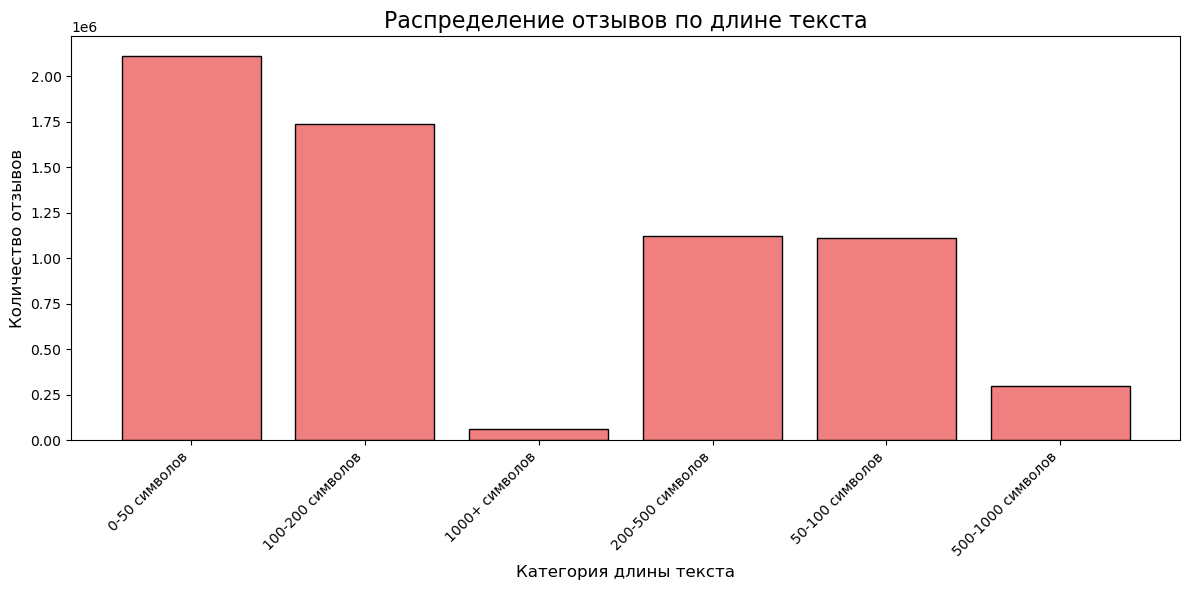


4. АНАЛИЗ ПУСТЫХ И КОРОТКИХ ОТЗЫВОВ:
Пустых отзывов (NULL): 0
Очень коротких отзывов (<10 символов): 0

5. КОРРЕЛЯЦИЯ ДЛИНЫ ОТЗЫВА С ОЦЕНКОЙ:
Оценка | Средняя длина текста | Количество отзывов
-------------------------------------------------------
1.0 | 188.08 символов | 446126
2.0 | 201.55 символов | 274155
3.0 | 184.91 символов | 498852
4.0 | 166.98 символов | 1059935
5.0 | 142.55 символов | 4160475


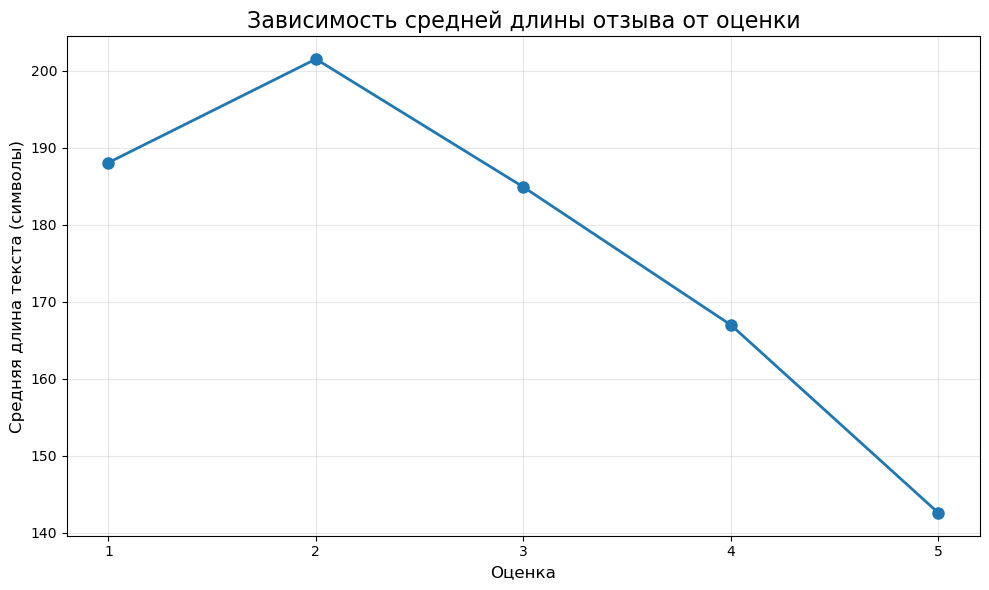


6. ПРИМЕРЫ САМЫХ ДЛИННЫХ ОТЗЫВОВ:
Топ-5 самых длинных отзывов:
1. Длина: 30046 символов, Оценка: 3.0
   Предпросмотр: Ubiquitous British funnyman Simon Pegg in a crazy sci-fi lark directed by Terry Jones of Monty Pytho...

2. Длина: 29411 символов, Оценка: 4.0
   Предпросмотр: recommend!  Great movie for the little ones.  I would recommend!  Great movie for the little ones.  ...

3. Длина: 29411 символов, Оценка: 3.0
   Предпросмотр: recommend!  Great movie for the little ones.  I would recommend!  Great movie for the little ones.  ...

4. Длина: 29411 символов, Оценка: 3.0
   Предпросмотр: recommend!  Great movie for the little ones.  I would recommend!  Great movie for the little ones.  ...

5. Длина: 29411 символов, Оценка: 4.0
   Предпросмотр: recommend!  Great movie for the little ones.  I would recommend!  Great movie for the little ones.  ...


7. ПРИМЕРЫ САМЫХ КОРОТКИХ ОТЗЫВОВ:
Топ-5 самых коротких отзывов (≥10 символов):
1. Длина: 10 символов, Оценка: 5.0
   Текст: Great DVD.

In [12]:
### Анализ столбца `reviewText` (текст отзыва)

print("=== АНАЛИЗ СТОЛБЦА REVIEWTEXT ====")
print("reviewText - текст отзыва\n")

# 1. Статистика по длине текста отзывов
print("1. СТАТИСТИКА ПО ДЛИНЕ ТЕКСТА ОТЗЫВОВ:")
review_length_stats = df_final.select(
    mean(length("reviewText")).alias("avg_length"),
    stddev(length("reviewText")).alias("std_length"),
    min(length("reviewText")).alias("min_length"),
    max(length("reviewText")).alias("max_length"),
    count("reviewText").alias("total_reviews")
).collect()[0]

print(f"Средняя длина отзыва: {review_length_stats['avg_length']:.2f} символов")
print(f"Стандартное отклонение: {review_length_stats['std_length']:.2f}")
print(f"Минимальная длина: {review_length_stats['min_length']} символов")
print(f"Максимальная длина: {review_length_stats['max_length']} символов")
print(f"Всего отзывов с текстом: {review_length_stats['total_reviews']}")

# 2. Распределение длины отзывов
print("\n2. РАСПРЕДЕЛЕНИЕ ДЛИНЫ ОТЗЫВОВ:")
# Создаем категории по длине текста
length_categories = df_final.select(
    when(length("reviewText") < 50, "0-50 символов")
    .when((length("reviewText") >= 50) & (length("reviewText") < 100), "50-100 символов")
    .when((length("reviewText") >= 100) & (length("reviewText") < 200), "100-200 символов")
    .when((length("reviewText") >= 200) & (length("reviewText") < 500), "200-500 символов")
    .when((length("reviewText") >= 500) & (length("reviewText") < 1000), "500-1000 символов")
    .otherwise("1000+ символов")
    .alias("length_category")
).groupBy("length_category").count().orderBy("length_category").collect()

total_rows = df_final.count()

print("Категория длины | Количество | Процент")
print("-" * 45)
for row in length_categories:
    percentage = (row['count'] / total_rows) * 100
    print(f"{row['length_category']} | {row['count']} | {percentage:.2f}%")

# 3. Визуализация распределения длины отзывов
print("\n3. ВИЗУАЛИЗАЦИЯ РАСПРЕДЕЛЕНИЯ ДЛИНЫ ОТЗЫВОВ:")
categories = [row['length_category'] for row in length_categories]
category_counts = [row['count'] for row in length_categories]

plt.figure(figsize=(12, 6))
plt.bar(categories, category_counts, color='lightcoral', edgecolor='black')
plt.title('Распределение отзывов по длине текста', fontsize=16)
plt.xlabel('Категория длины текста', fontsize=12)
plt.ylabel('Количество отзывов', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 4. Анализ пустых отзывов
print("\n4. АНАЛИЗ ПУСТЫХ И КОРОТКИХ ОТЗЫВОВ:")
empty_reviews = df_final.filter(col("reviewText").isNull()).count()
short_reviews = df_final.filter((length("reviewText") < 10) & (col("reviewText").isNotNull())).count()
print(f"Пустых отзывов (NULL): {empty_reviews}")
print(f"Очень коротких отзывов (<10 символов): {short_reviews}")

# 5. Корреляция длины отзыва с оценкой
print("\n5. КОРРЕЛЯЦИЯ ДЛИНЫ ОТЗЫВА С ОЦЕНКОЙ:")
correlation_data = df_final.filter(col("reviewText").isNotNull()).select(
    "overall",
    length("reviewText").alias("text_length")
)

# Группируем по оценкам и вычисляем среднюю длину
avg_length_by_rating = correlation_data.groupBy("overall").agg(
    mean("text_length").alias("avg_text_length"),
    count("*").alias("count")
).orderBy("overall").collect()

print("Оценка | Средняя длина текста | Количество отзывов")
print("-" * 55)
for row in avg_length_by_rating:
    print(f"{row['overall']} | {row['avg_text_length']:.2f} символов | {row['count']}")

# Визуализация зависимости длины от оценки
ratings = [float(row['overall']) for row in avg_length_by_rating]
avg_lengths = [float(row['avg_text_length']) for row in avg_length_by_rating]

plt.figure(figsize=(10, 6))
plt.plot(ratings, avg_lengths, marker='o', linewidth=2, markersize=8)
plt.title('Зависимость средней длины отзыва от оценки', fontsize=16)
plt.xlabel('Оценка', fontsize=12)
plt.ylabel('Средняя длина текста (символы)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(ratings)
plt.tight_layout()
plt.show()

# 6. Анализ самых длинных отзывов
print("\n6. ПРИМЕРЫ САМЫХ ДЛИННЫХ ОТЗЫВОВ:")
longest_reviews = df_final.select(
    "reviewText", 
    length("reviewText").alias("text_length"),
    "overall"
).orderBy(desc("text_length")).collect()

print("Топ-5 самых длинных отзывов:")
for i, row in enumerate(longest_reviews[:5], 1):
    preview = row['reviewText'][:100] + "..." if row['reviewText'] and len(row['reviewText']) > 100 else row['reviewText']
    print(f"{i}. Длина: {row['text_length']} символов, Оценка: {row['overall']}")
    print(f"   Предпросмотр: {preview}")
    print()

# 7. Анализ самых коротких непустых отзывов
print("\n7. ПРИМЕРЫ САМЫХ КОРОТКИХ ОТЗЫВОВ:")
shortest_reviews = df_final.filter(
    col("reviewText").isNotNull() & (length("reviewText") >= 10)
).select(
    "reviewText", 
    length("reviewText").alias("text_length"),
    "overall"
).orderBy("text_length").collect()

print("Топ-5 самых коротких отзывов (≥10 символов):")
for i, row in enumerate(shortest_reviews[:5], 1):
    print(f"{i}. Длина: {row['text_length']} символов, Оценка: {row['overall']}")
    print(f"   Текст: {row['reviewText']}")
    print()




### Анализ столбца `summary` (текстовый признак)

=== АНАЛИЗ СТОЛБЦА SUMMARY ====
summary - краткое описание/заголовок отзыва

1. СТАТИСТИКА ПО ДЛИНЕ SUMMARY:
Средняя длина summary: 20.64 символов
Стандартное отклонение: 17.14
Минимальная длина: 1 символов
Максимальная длина: 1139 символов
Всего summary: 6439543

2. РАСПРЕДЕЛЕНИЕ ДЛИНЫ SUMMARY:
Категория длины | Количество | Процент
---------------------------------------------
0-10 символов | 781735 | 12.14%
10-20 символов | 3420392 | 53.12%
100+ символов | 26080 | 0.40%
20-30 символов | 888625 | 13.80%
30-50 символов | 838788 | 13.03%
50-100 символов | 483923 | 7.51%

3. ВИЗУАЛИЗАЦИЯ РАСПРЕДЕЛЕНИЯ ДЛИНЫ SUMMARY:


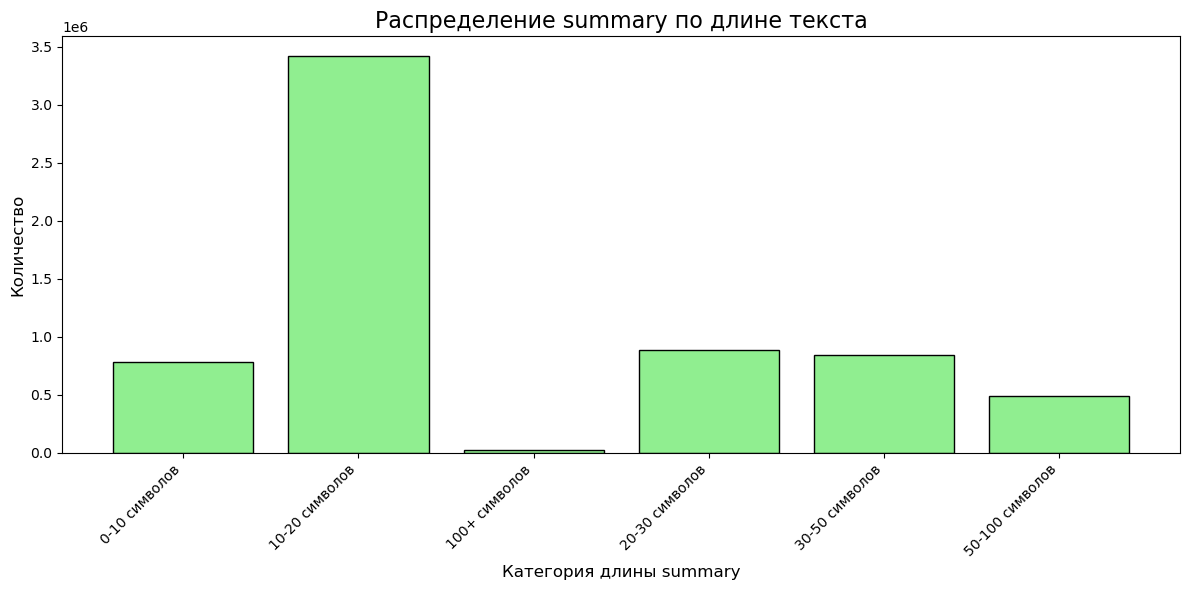


4. САМЫЕ ПОПУЛЯРНЫЕ SUMMARY:
Топ-20 самых популярных summary:
Summary | Количество | Процент
--------------------------------------------------
Five Stars | 1424714 | 22.12%
Four Stars | 334050 | 5.19%
Three Stars | 139033 | 2.16%
One Star | 110443 | 1.72%
Two Stars | 69660 | 1.08%
Great movie | 24245 | 0.38%
Great Movie | 16974 | 0.26%
Great | 16593 | 0.26%
Good movie | 13421 | 0.21%
Awesome | 11725 | 0.18%
Great movie! | 10989 | 0.17%
Excellent | 10845 | 0.17%
Love it! | 9735 | 0.15%
Love it | 8867 | 0.14%
great movie | 8474 | 0.13%
Great! | 7776 | 0.12%
Good | 7348 | 0.11%
great | 7078 | 0.11%
Good Movie | 6911 | 0.11%
Loved it! | 6533 | 0.10%

5. ВИЗУАЛИЗАЦИЯ ТОП SUMMARY:


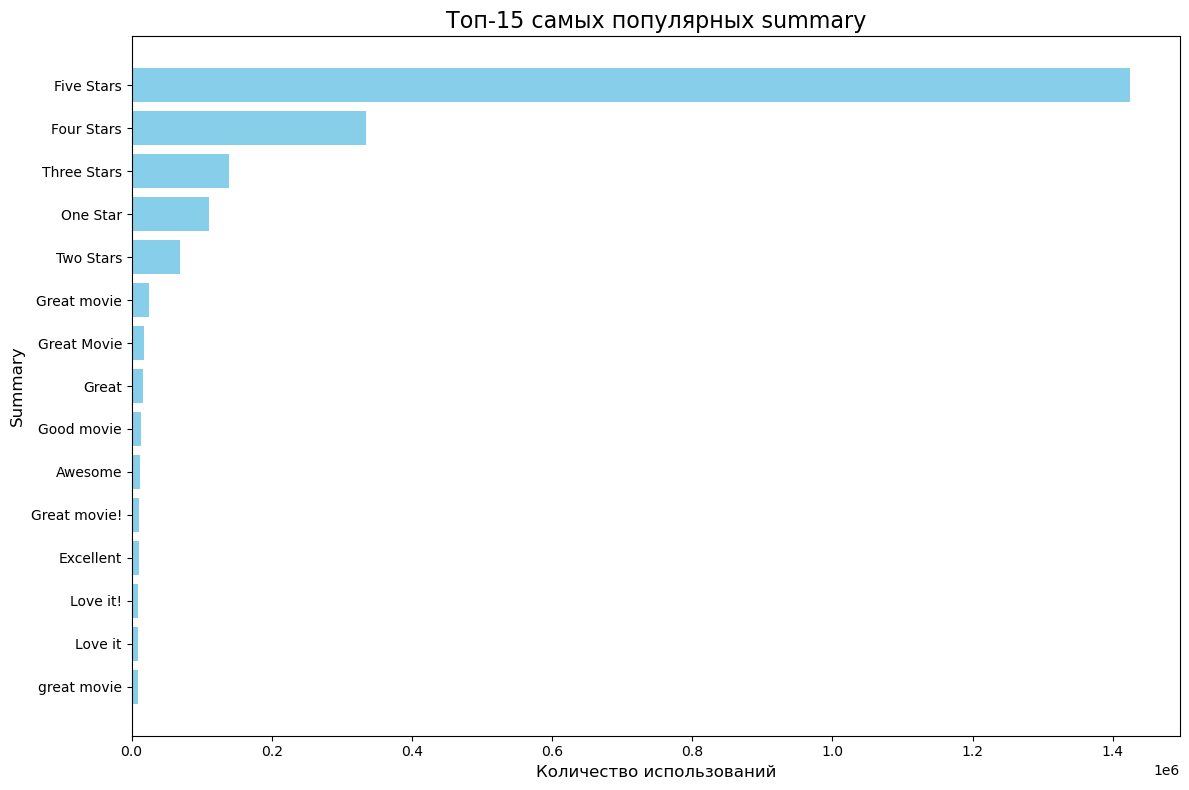


6. КОРРЕЛЯЦИЯ ДЛИНЫ SUMMARY С ОЦЕНКОЙ:
Оценка | Средняя длина summary | Количество
-------------------------------------------------------
1.0 | 22.63 символов | 446126
2.0 | 23.11 символов | 274155
3.0 | 23.08 символов | 498852
4.0 | 21.24 символов | 1059935
5.0 | 19.82 символов | 4160475


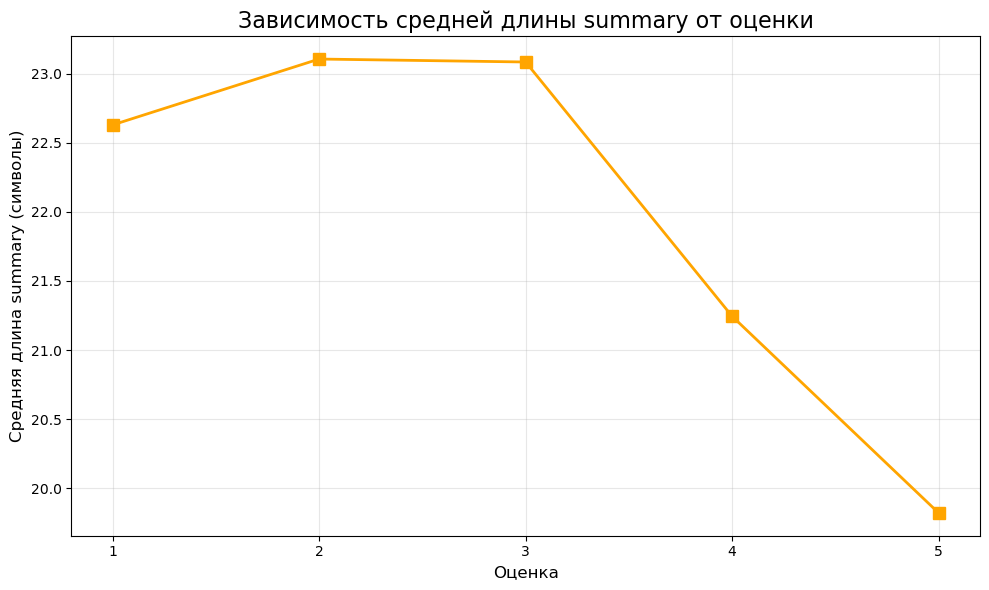


7. АНАЛИЗ УНИКАЛЬНОСТИ SUMMARY:
Уникальных summary: 2604294
Всего summary: 6439543
Процент уникальных summary: 40.44%

8. ПРИМЕРЫ САМЫХ ДЛИННЫХ SUMMARY:
Топ-5 самых длинных summary:
1. Длина: 1139 символов, Оценка: 5.0
   Текст: If it's a classic I thought I should read it and it turned out to be somewhat entertaining I'm not religious so I was surprised that I was as interested as I was otherwise it kept me going and I was hoping to finish it open my eyes to that period of time which made it the most interesting of the book otherwise it was too religious for me and I'm not that religious so I prefer not to read any more religious books because I don't not believe I hope this is enough words to complete this review but I just trying to fill it in don't have much more to say hope this is enough want to continue religious but but it was a informative view of the Jewish life and Gina Jesus's final day the way of life at the time was in lightning and I don't know I enjoy the book but tell

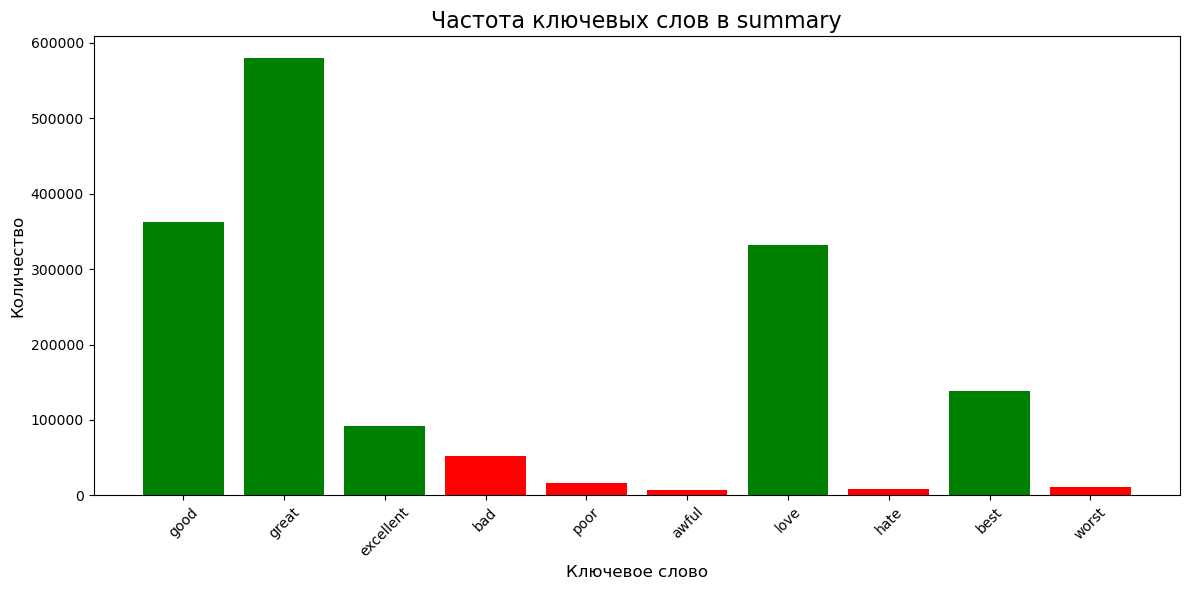


11. АНАЛИЗ SUMMARY С ЗНАЧЕНИЕМ 'Unknown':
Summary со значением 'Unknown': 1498
Процент от общего количества: 0.02%


In [12]:
### Анализ столбца `summary` (краткое описание отзыва)

print("=== АНАЛИЗ СТОЛБЦА SUMMARY ====")
print("summary - краткое описание/заголовок отзыва\n")

# 1. Статистика по длине summary
print("1. СТАТИСТИКА ПО ДЛИНЕ SUMMARY:")
summary_stats = df_final.select(
    mean(length("summary")).alias("avg_length"),
    stddev(length("summary")).alias("std_length"),
    min(length("summary")).alias("min_length"),
    max(length("summary")).alias("max_length"),
    count("summary").alias("total_summaries")
).collect()[0]

print(f"Средняя длина summary: {summary_stats['avg_length']:.2f} символов")
print(f"Стандартное отклонение: {summary_stats['std_length']:.2f}")
print(f"Минимальная длина: {summary_stats['min_length']} символов")
print(f"Максимальная длина: {summary_stats['max_length']} символов")
print(f"Всего summary: {summary_stats['total_summaries']}")

# 2. Распределение длины summary
print("\n2. РАСПРЕДЕЛЕНИЕ ДЛИНЫ SUMMARY:")
# Создаем категории по длине summary
summary_length_categories = df_final.select(
    when(length("summary") < 10, "0-10 символов")
    .when((length("summary") >= 10) & (length("summary") < 20), "10-20 символов")
    .when((length("summary") >= 20) & (length("summary") < 30), "20-30 символов")
    .when((length("summary") >= 30) & (length("summary") < 50), "30-50 символов")
    .when((length("summary") >= 50) & (length("summary") < 100), "50-100 символов")
    .otherwise("100+ символов")
    .alias("length_category")
).groupBy("length_category").count().orderBy("length_category").collect()

total_rows = df_final.count()

print("Категория длины | Количество | Процент")
print("-" * 45)
for row in summary_length_categories:
    percentage = (row['count'] / total_rows) * 100
    print(f"{row['length_category']} | {row['count']} | {percentage:.2f}%")

# 3. Визуализация распределения длины summary
print("\n3. ВИЗУАЛИЗАЦИЯ РАСПРЕДЕЛЕНИЯ ДЛИНЫ SUMMARY:")
categories = [row['length_category'] for row in summary_length_categories]
category_counts = [row['count'] for row in summary_length_categories]

plt.figure(figsize=(12, 6))
plt.bar(categories, category_counts, color='lightgreen', edgecolor='black')
plt.title('Распределение summary по длине текста', fontsize=16)
plt.xlabel('Категория длины summary', fontsize=12)
plt.ylabel('Количество', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 4. Анализ самых популярных summary
print("\n4. САМЫЕ ПОПУЛЯРНЫЕ SUMMARY:")
top_summaries = df_final.groupBy("summary").count().orderBy(desc("count")).collect()

print("Топ-20 самых популярных summary:")
print("Summary | Количество | Процент")
print("-" * 50)
for row in top_summaries[:20]:
    percentage = (row['count'] / total_rows) * 100
    print(f"{row['summary']} | {row['count']} | {percentage:.2f}%")

# 5. Визуализация топ summary
print("\n5. ВИЗУАЛИЗАЦИЯ ТОП SUMMARY:")
top_summaries_for_plot = [(row['summary'], row['count']) for row in top_summaries[:15]]
summary_texts, summary_counts = zip(*top_summaries_for_plot)

plt.figure(figsize=(12, 8))
plt.barh(summary_texts, summary_counts, color='skyblue')
plt.title('Топ-15 самых популярных summary', fontsize=16)
plt.xlabel('Количество использований', fontsize=12)
plt.ylabel('Summary', fontsize=12)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# 6. Анализ корреляции длины summary с оценкой
print("\n6. КОРРЕЛЯЦИЯ ДЛИНЫ SUMMARY С ОЦЕНКОЙ:")
summary_length_by_rating = df_final.groupBy("overall").agg(
    mean(length("summary")).alias("avg_summary_length"),
    count("*").alias("count")
).orderBy("overall").collect()

print("Оценка | Средняя длина summary | Количество")
print("-" * 55)
for row in summary_length_by_rating:
    print(f"{row['overall']} | {row['avg_summary_length']:.2f} символов | {row['count']}")

# Визуализация зависимости длины summary от оценки
ratings = [float(row['overall']) for row in summary_length_by_rating]
avg_summary_lengths = [float(row['avg_summary_length']) for row in summary_length_by_rating]

plt.figure(figsize=(10, 6))
plt.plot(ratings, avg_summary_lengths, marker='s', linewidth=2, markersize=8, color='orange')
plt.title('Зависимость средней длины summary от оценки', fontsize=16)
plt.xlabel('Оценка', fontsize=12)
plt.ylabel('Средняя длина summary (символы)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(ratings)
plt.tight_layout()
plt.show()

# 7. Анализ уникальных summary
print("\n7. АНАЛИЗ УНИКАЛЬНОСТИ SUMMARY:")
unique_summaries_count = df_final.select("summary").distinct().count()
total_summaries = df_final.count()
unique_ratio = (unique_summaries_count / total_summaries) * 100

print(f"Уникальных summary: {unique_summaries_count}")
print(f"Всего summary: {total_summaries}")
print(f"Процент уникальных summary: {unique_ratio:.2f}%")

# 8. Анализ самых длинных summary
print("\n8. ПРИМЕРЫ САМЫХ ДЛИННЫХ SUMMARY:")
longest_summaries = df_final.select(
    "summary", 
    length("summary").alias("summary_length"),
    "overall"
).orderBy(desc("summary_length")).collect()

print("Топ-5 самых длинных summary:")
for i, row in enumerate(longest_summaries[:5], 1):
    print(f"{i}. Длина: {row['summary_length']} символов, Оценка: {row['overall']}")
    print(f"   Текст: {row['summary']}")
    print()

# 9. Анализ самых коротких summary
print("\n9. ПРИМЕРЫ САМЫХ КОРОТКИХ SUMMARY:")
shortest_summaries = df_final.filter(
    col("summary").isNotNull() & (length("summary") >= 1)
).select(
    "summary", 
    length("summary").alias("summary_length"),
    "overall"
).orderBy("summary_length").collect()

print("Топ-5 самых коротких summary:")
for i, row in enumerate(shortest_summaries[:5], 1):
    print(f"{i}. Длина: {row['summary_length']} символов, Оценка: {row['overall']}")
    print(f"   Текст: {row['summary']}")
    print()

# 10. Анализ summary содержащих ключевые слова
print("\n10. АНАЛИЗ SUMMARY ПО КЛЮЧЕВЫМ СЛОВАМ:")
keywords = ["good", "great", "excellent", "bad", "poor", "awful", "love", "hate", "best", "worst"]

keyword_analysis = []
for keyword in keywords:
    keyword_count = df_final.filter(lower(col("summary")).contains(keyword)).count()
    keyword_percentage = (keyword_count / total_rows) * 100
    keyword_analysis.append((keyword, keyword_count, keyword_percentage))

print("Ключевое слово | Количество | Процент")
print("-" * 45)
for keyword, count, percentage in keyword_analysis:
    print(f"{keyword} | {count} | {percentage:.2f}%")

# Визуализация ключевых слов
keywords_list, counts_list, percentages_list = zip(*keyword_analysis)

plt.figure(figsize=(12, 6))
plt.bar(keywords_list, counts_list, color=['green' if kw in ['good', 'great', 'excellent', 'love', 'best'] else 'red' for kw in keywords_list])
plt.title('Частота ключевых слов в summary', fontsize=16)
plt.xlabel('Ключевое слово', fontsize=12)
plt.ylabel('Количество', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 11. Анализ summary с оценкой "Unknown"
print("\n11. АНАЛИЗ SUMMARY С ЗНАЧЕНИЕМ 'Unknown':")
unknown_summaries = df_final.filter(col("summary") == "Unknown").count()
print(f"Summary со значением 'Unknown': {unknown_summaries}")
print(f"Процент от общего количества: {(unknown_summaries / total_rows) * 100:.2f}%")


### Анализ столбца `unixReviewTime` (временной признак)

=== АНАЛИЗ СТОЛБЦА UNIXREVIEWTIME ====
unixReviewTime - временная метка отзыва (временной признак)

1. ПРОВЕРКА NULL ЗНАЧЕНИЙ:
NULL значений в unixReviewTime: 0

2. БАЗОВАЯ СТАТИСТИКА:
Метрика | Значение
--------------------
count | 6439543
mean | 1.4104084789614418E9
stddev | 9.114636196261744E7
min | 946684800
max | 1538524800

3. ПРЕОБРАЗОВАНИЕ В ДАТУ И АНАЛИЗ РАСПРЕДЕЛЕНИЯ:
Распределение отзывов по годам:
Год | Количество отзывов
------------------------------
2000 | 27482
2001 | 25972
2002 | 24398
2003 | 24159
2004 | 30412
2005 | 40110
2006 | 43923
2007 | 78513
2008 | 80878
2009 | 96021
2010 | 93653
2011 | 109936
2012 | 216633
2013 | 687180
2014 | 1118033
2015 | 1429621
2016 | 1542052
2017 | 574629
2018 | 195938

4. ВИЗУАЛИЗАЦИЯ РАСПРЕДЕЛЕНИЯ ПО ГОДАМ:


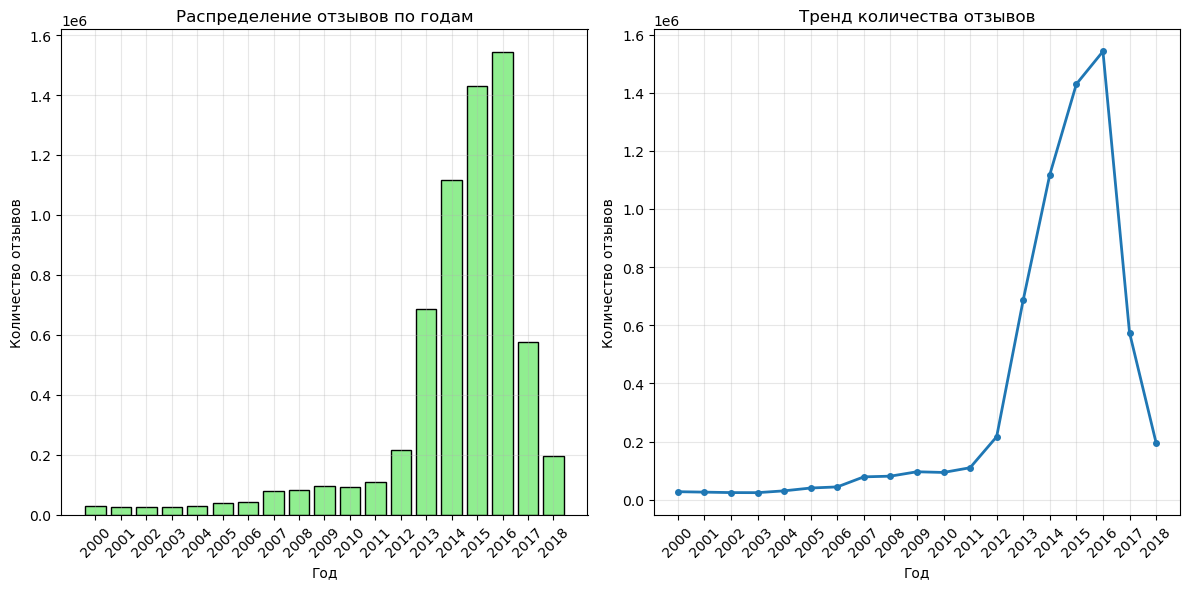


5. АНАЛИЗ СЕЗОННОСТИ ПО МЕСЯЦАМ:
Распределение по месяцам:
Месяц | Количество отзывов
------------------------------
Янв (1) | 693148
Фев (2) | 574936
Мар (3) | 597269
Апр (4) | 480094
Май (5) | 510991
Июн (6) | 497360
Июл (7) | 532490
Авг (8) | 515077
Сен (9) | 508885
Окт (10) | 491145
Ноя (11) | 455907
Дек (12) | 582241


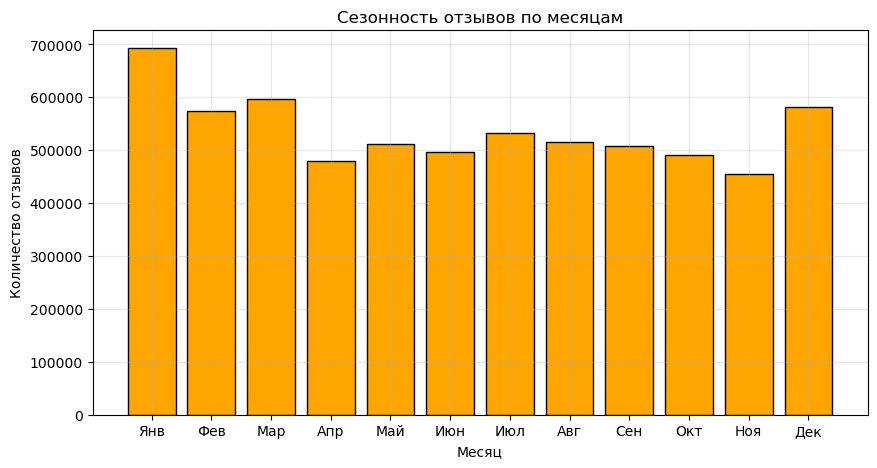


6. ПРОВЕРКА КОРРЕКТНОСТИ ВРЕМЕННЫХ МЕТОК:
Минимальная временная метка: 946684800 (2000-01-01 00:00:00)
Максимальная временная метка: 1538524800 (2018-10-03 00:00:00)
Отзывов до 2000 года: 0
Отзывов после 2020 года: 0

7. СРЕДНЯЯ ОЦЕНКА ПО ГОДАМ:
Средняя оценка по годам:
Год | Средняя оценка | Количество отзывов
---------------------------------------------
2000 | 4.139 | 27482
2001 | 4.098 | 25972
2002 | 4.131 | 24398
2003 | 4.107 | 24159
2004 | 4.012 | 30412
2005 | 4.018 | 40110
2006 | 4.153 | 43923
2007 | 4.297 | 78513
2008 | 4.228 | 80878
2009 | 4.200 | 96021
2010 | 4.162 | 93653
2011 | 4.161 | 109936
2012 | 4.240 | 216633
2013 | 4.321 | 687180
2014 | 4.313 | 1118033
2015 | 4.281 | 1429621
2016 | 4.265 | 1542052
2017 | 4.297 | 574629
2018 | 4.292 | 195938


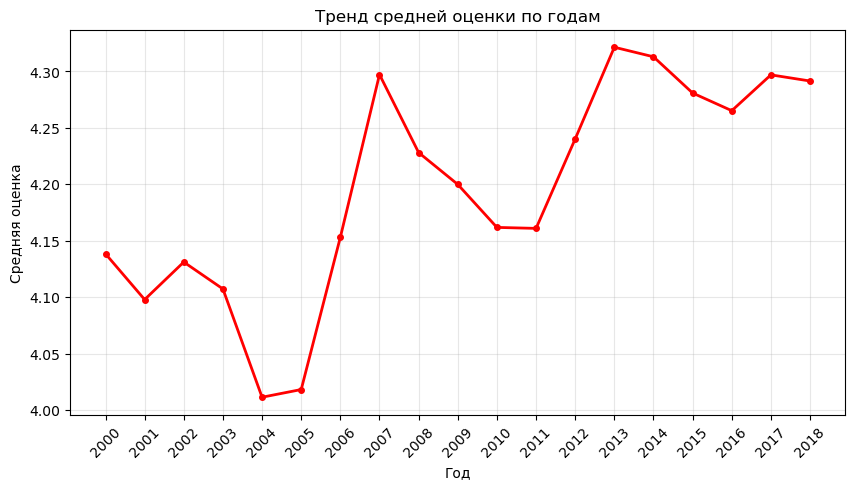

In [18]:
print("=== АНАЛИЗ СТОЛБЦА UNIXREVIEWTIME ====")
print("unixReviewTime - временная метка отзыва (временной признак)")

# 1. Проверка на NULL значения
print("\n1. ПРОВЕРКА NULL ЗНАЧЕНИЙ:")
unix_null_count = df_final.filter(col("unixReviewTime").isNull()).count()
print(f"NULL значений в unixReviewTime: {unix_null_count}")

# 2. Базовая статистика
print("\n2. БАЗОВАЯ СТАТИСТИКА:")
stats_collected = df_final.select("unixReviewTime").describe().collect()
print("Метрика | Значение")
print("-" * 20)
for row in stats_collected:
    print(f"{row['summary']} | {row['unixReviewTime']}")

# 3. Преобразование в читаемую дату и анализ распределения
print("\n3. ПРЕОБРАЗОВАНИЕ В ДАТУ И АНАЛИЗ РАСПРЕДЕЛЕНИЯ:")
df_with_dates = df_final.withColumn("review_date", from_unixtime("unixReviewTime")) \
                       .withColumn("review_year", year("review_date")) \
                       .withColumn("review_month", month("review_date")) \
                       .withColumn("review_day", dayofmonth("review_date"))

# Анализ по годам
print("Распределение отзывов по годам:")
yearly_distribution_collected = df_with_dates.groupBy("review_year").count().orderBy("review_year").collect()

print("Год | Количество отзывов")
print("-" * 30)
for row in yearly_distribution_collected:
    print(f"{int(row['review_year'])} | {row['count']}")

# 4. Визуализация распределения по годам
print("\n4. ВИЗУАЛИЗАЦИЯ РАСПРЕДЕЛЕНИЯ ПО ГОДАМ:")
years = [int(row['review_year']) for row in yearly_distribution_collected]
counts = [row['count'] for row in yearly_distribution_collected]

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(years, counts, color='lightgreen', edgecolor='black')
plt.xlabel("Год")
plt.ylabel("Количество отзывов")
plt.title("Распределение отзывов по годам")
plt.xticks(years, rotation=45)
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(years, counts, marker='o', linewidth=2, markersize=4)
plt.xlabel("Год")
plt.ylabel("Количество отзывов")
plt.title("Тренд количества отзывов")
plt.xticks(years, rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 5. Анализ по месяцам (сезонность)
print("\n5. АНАЛИЗ СЕЗОННОСТИ ПО МЕСЯЦАМ:")
monthly_distribution_collected = df_with_dates.groupBy("review_month").count().orderBy("review_month").collect()

print("Распределение по месяцам:")
print("Месяц | Количество отзывов")
print("-" * 30)
month_names = ['Янв', 'Фев', 'Мар', 'Апр', 'Май', 'Июн', 'Июл', 'Авг', 'Сен', 'Окт', 'Ноя', 'Дек']
for row in monthly_distribution_collected:
    month_name = month_names[int(row['review_month']) - 1]
    print(f"{month_name} ({int(row['review_month'])}) | {row['count']}")

# Визуализация сезонности
months = [month_names[int(row['review_month']) - 1] for row in monthly_distribution_collected]
month_counts = [row['count'] for row in monthly_distribution_collected]

plt.figure(figsize=(10, 5))
plt.bar(months, month_counts, color='orange', edgecolor='black')
plt.xlabel("Месяц")
plt.ylabel("Количество отзывов")
plt.title("Сезонность отзывов по месяцам")
plt.grid(True, alpha=0.3)
plt.show()

# 6. Проверка корректности временных меток
print("\n6. ПРОВЕРКА КОРРЕКТНОСТИ ВРЕМЕННЫХ МЕТОК:")
min_timestamp = df_final.agg(min("unixReviewTime")).collect()[0][0]
max_timestamp = df_final.agg(max("unixReviewTime")).collect()[0][0]

# Для преобразования timestamp в дату используем отдельный запрос
min_date = df_final.select(from_unixtime(min("unixReviewTime")).alias("min_date")).collect()[0][0]
max_date = df_final.select(from_unixtime(max("unixReviewTime")).alias("max_date")).collect()[0][0]

print(f"Минимальная временная метка: {min_timestamp} ({min_date})")
print(f"Максимальная временная метка: {max_timestamp} ({max_date})")

# Проверка на выбросы (до 2000 года или будущее время)
outdated_reviews = df_final.filter(col("unixReviewTime") < 946684800)  # до 2000-01-01
future_reviews = df_final.filter(col("unixReviewTime") > 1577836800)   # после 2020-01-01
print(f"Отзывов до 2000 года: {outdated_reviews.count()}")
print(f"Отзывов после 2020 года: {future_reviews.count()}")

# 7. Анализ средней оценки по годам
print("\n7. СРЕДНЯЯ ОЦЕНКА ПО ГОДАМ:")
yearly_ratings_collected = df_with_dates.groupBy("review_year").agg(
    mean("overall").alias("avg_rating"),
    sum(lit(1)).alias("review_count")  # Используем sum(lit(1)) вместо count
).orderBy("review_year").collect()

print("Средняя оценка по годам:")
print("Год | Средняя оценка | Количество отзывов")
print("-" * 45)
for row in yearly_ratings_collected:
    print(f"{int(row['review_year'])} | {row['avg_rating']:.3f} | {row['review_count']}")

# Визуализация тренда оценок
years_rating = [int(row['review_year']) for row in yearly_ratings_collected]
avg_ratings = [float(row['avg_rating']) for row in yearly_ratings_collected]

plt.figure(figsize=(10, 5))
plt.plot(years_rating, avg_ratings, marker='o', linewidth=2, markersize=4, color='red')
plt.xlabel("Год")
plt.ylabel("Средняя оценка")
plt.title("Тренд средней оценки по годам")
plt.xticks(years_rating, rotation=45)
plt.grid(True, alpha=0.3)
plt.show()



### Анализ столбца `reviewTime` (временной признак

=== АНАЛИЗ СТОЛБЦА REVIEWTIME ====
reviewTime - дата отзыва в формате YYYY-MM-DD

1. СТАТИСТИКА ПО ДАТАМ ОТЗЫВОВ:
Самая ранняя дата: 2000-01-01
Самая поздняя дата: 2018-12-09
Всего записей с датами: 6439543
Уникальных дат: 6850

2. АНАЛИЗ ПРОПУЩЕННЫХ ЗНАЧЕНИЙ:
NULL значений в reviewTime: 0
Значений 'Unknown' в reviewTime: 0
Всего корректных дат: 6439543

3. РАСПРЕДЕЛЕНИЕ ОТЗЫВОВ ПО ГОДАМ (ИЗ REVIEWTIME):
Год | Количество отзывов | Процент
---------------------------------------------
2000 | 27482 | 0.43%
2001 | 25972 | 0.40%
2002 | 24398 | 0.38%
2003 | 24159 | 0.38%
2004 | 30412 | 0.47%
2005 | 40110 | 0.62%
2006 | 43923 | 0.68%
2007 | 78513 | 1.22%
2008 | 80878 | 1.26%
2009 | 96021 | 1.49%
2010 | 93653 | 1.45%
2011 | 109936 | 1.71%
2012 | 216633 | 3.36%
2013 | 687180 | 10.67%
2014 | 1118033 | 17.36%
2015 | 1429621 | 22.20%
2016 | 1542052 | 23.95%
2017 | 574629 | 8.92%
2018 | 195938 | 3.04%

4. СРАВНЕНИЕ С UNIXREVIEWTIME:
Несогласованных дат между reviewTime и unixReviewTime: 2356632
Пр

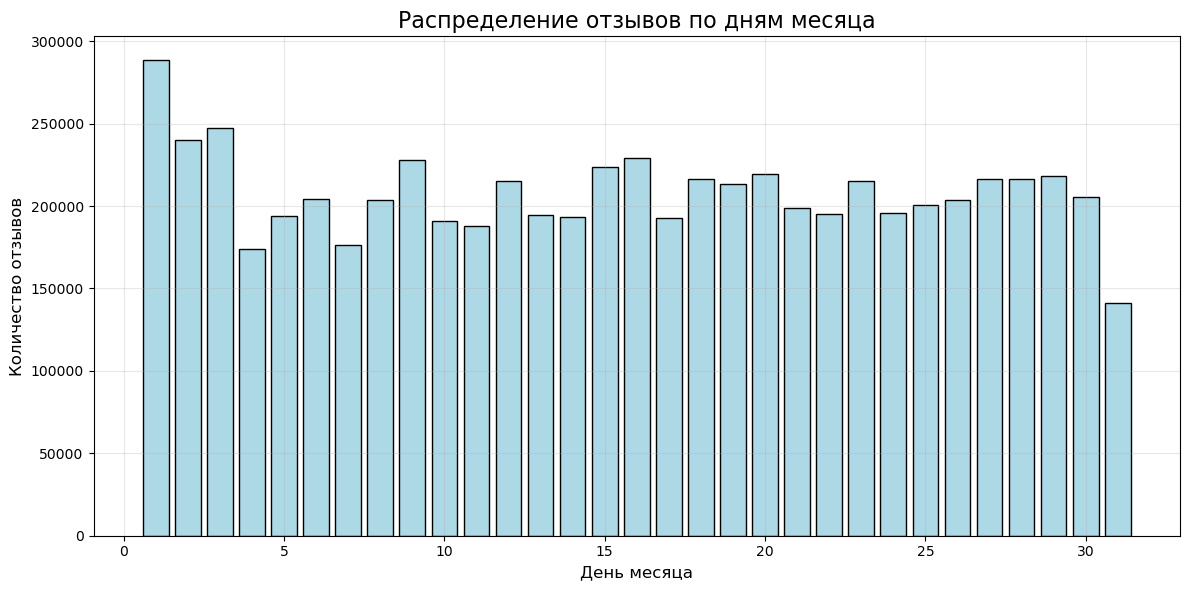

In [22]:
### Анализ столбца `reviewTime` (дата отзыва)

print("=== АНАЛИЗ СТОЛБЦА REVIEWTIME ====")
print("reviewTime - дата отзыва в формате YYYY-MM-DD\n")

# 1. Статистика по датам отзывов
print("1. СТАТИСТИКА ПО ДАТАМ ОТЗЫВОВ:")
date_stats = df_final.select(
    min("reviewTime").alias("min_date"),
    max("reviewTime").alias("max_date"),
    sum(lit(1)).alias("total_dates"),
    countDistinct("reviewTime").alias("unique_dates")
).collect()[0]

print(f"Самая ранняя дата: {date_stats['min_date']}")
print(f"Самая поздняя дата: {date_stats['max_date']}")
print(f"Всего записей с датами: {date_stats['total_dates']}")
print(f"Уникальных дат: {date_stats['unique_dates']}")

# 2. Анализ пропущенных значений
print("\n2. АНАЛИЗ ПРОПУЩЕННЫХ ЗНАЧЕНИЙ:")
null_reviewtime = df_final.filter(col("reviewTime").isNull()).count()
unknown_reviewtime = df_final.filter(col("reviewTime") == "Unknown").count()

print(f"NULL значений в reviewTime: {null_reviewtime}")
print(f"Значений 'Unknown' в reviewTime: {unknown_reviewtime}")
print(f"Всего корректных дат: {date_stats['total_dates'] - unknown_reviewtime}")

# 3. Преобразование дат и анализ распределения
print("\n3. РАСПРЕДЕЛЕНИЕ ОТЗЫВОВ ПО ГОДАМ (ИЗ REVIEWTIME):")
# Преобразуем строку в дату
df_with_proper_dates = df_final.filter(
    col("reviewTime").isNotNull() & 
    (col("reviewTime") != "Unknown") &
    col("reviewTime").rlike(r"^\d{4}-\d{2}-\d{2}$")
).withColumn("review_date", to_date(col("reviewTime"), "yyyy-MM-dd"))

reviews_by_year_date = df_with_proper_dates.select(
    year("review_date").alias("year")
).groupBy("year").count().orderBy("year").collect()

print("Год | Количество отзывов | Процент")
print("-" * 45)
total_valid_dates = df_with_proper_dates.count()
for row in reviews_by_year_date:
    percentage = (row['count'] / total_valid_dates) * 100
    print(f"{row['year']} | {row['count']} | {percentage:.2f}%")

# 4. Сравнение с unixReviewTime
print("\n4. СРАВНЕНИЕ С UNIXREVIEWTIME:")
# Проверяем согласованность данных
inconsistent_dates = df_final.filter(
    col("reviewTime").isNotNull() & 
    (col("reviewTime") != "Unknown") &
    col("unixReviewTime").isNotNull() &
    col("reviewTime").rlike(r"^\d{4}-\d{2}-\d{2}$")
).withColumn(
    "calculated_date", 
    date_format(from_unixtime("unixReviewTime"), "yyyy-MM-dd")
).filter(col("reviewTime") != col("calculated_date"))

inconsistent_count = inconsistent_dates.count()
print(f"Несогласованных дат между reviewTime и unixReviewTime: {inconsistent_count}")
print(f"Процент несогласованных дат: {(inconsistent_count / total_valid_dates) * 100:.2f}%")

# 5. Анализ самых активных дней
print("\n5. САМЫЕ АКТИВНЫЕ ДНИ:")
top_days = df_with_proper_dates.groupBy("review_date").count().orderBy(desc("count")).collect()

print("Топ-10 самых активных дней:")
print("Дата | Количество отзывов")
print("-" * 35)
for row in top_days[:10]:
    print(f"{row['review_date']} | {row['count']}")

# 6. Анализ дней с максимальной активностью
print("\n6. АНАЛИЗ ДНЕЙ С МАКСИМАЛЬНОЙ АКТИВНОСТЬЮ:")
if len(top_days) > 0:
    max_day = top_days[0]
    print(f"Самый активный день: {max_day['review_date']}")
    print(f"Количество отзывов в этот день: {max_day['count']}")
    
    # Анализ отзывов в самый активный день
    max_day_reviews = df_with_proper_dates.filter(col("review_date") == max_day['review_date'])
    max_day_stats = max_day_reviews.agg(
        mean("overall").alias("avg_rating"),
        countDistinct("asin").alias("unique_products"),
        countDistinct("reviewerID").alias("unique_reviewers")
    ).collect()[0]
    
    print(f"Средняя оценка в этот день: {max_day_stats['avg_rating']:.2f}")
    print(f"Уникальных продуктов: {max_day_stats['unique_products']}")
    print(f"Уникальных рецензентов: {max_day_stats['unique_reviewers']}")

# 7. Анализ распределения по дням месяца
print("\n7. РАСПРЕДЕЛЕНИЕ ПО ДНЯМ МЕСЯЦА:")
reviews_by_day_of_month = df_with_proper_dates.select(
    dayofmonth("review_date").alias("day_of_month")
).groupBy("day_of_month").count().orderBy("day_of_month").collect()

print("День месяца | Количество отзывов | Процент")
print("-" * 50)
for row in reviews_by_day_of_month:
    percentage = (row['count'] / total_valid_dates) * 100
    print(f"{row['day_of_month']} | {row['count']} | {percentage:.2f}%")

# 8. Визуализация распределения по дням месяца
print("\n8. ВИЗУАЛИЗАЦИЯ РАСПРЕДЕЛЕНИЯ ПО ДНЯМ МЕСЯЦА:")
days = [row['day_of_month'] for row in reviews_by_day_of_month]
day_counts = [row['count'] for row in reviews_by_day_of_month]

plt.figure(figsize=(12, 6))
plt.bar(days, day_counts, color='lightblue', edgecolor='black')
plt.title('Распределение отзывов по дням месяца', fontsize=16)
plt.xlabel('День месяца', fontsize=12)
plt.ylabel('Количество отзывов', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()





### Итоговый анализ и корреляции 

=== ИТОГОВЫЙ АНАЛИЗ ДАННЫХ ===
=== КОРРЕЛЯЦИОННЫЙ АНАЛИЗ И ВЫВОДЫ ===

1. ПОДГОТОВКА ДАННЫХ ДЛЯ КОРРЕЛЯЦИОННОГО АНАЛИЗА:

2. КОРРЕЛЯЦИОННАЯ МАТРИЦА ЧИСЛОВЫХ ПРИЗНАКОВ:


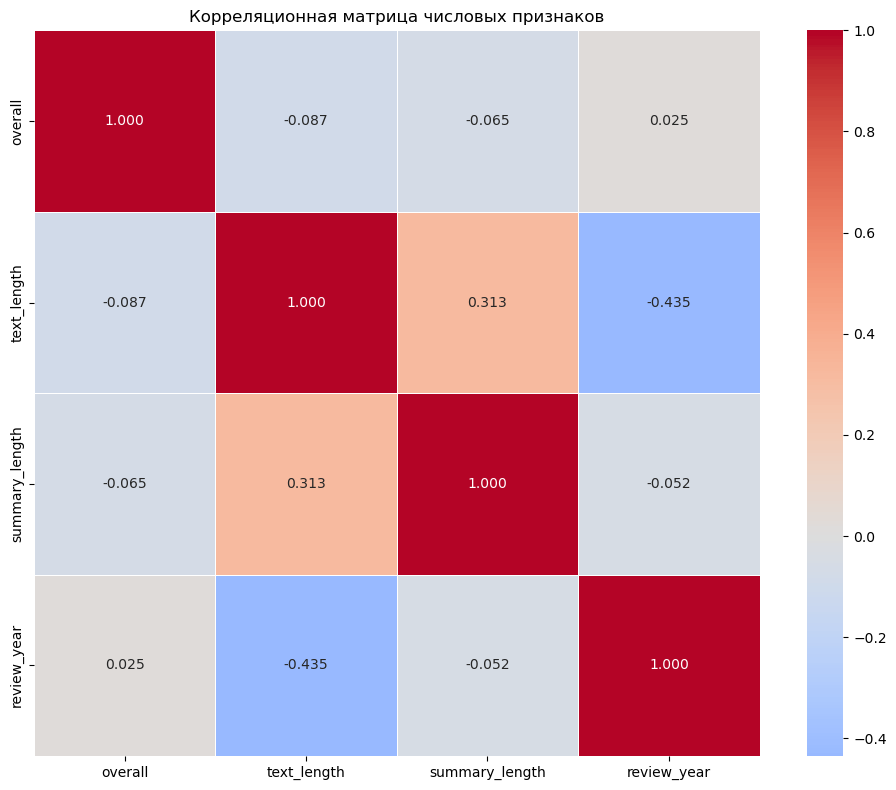


3. АНАЛИЗ КЛЮЧЕВЫХ КОРРЕЛЯЦИЙ:
Наиболее значимые корреляции:
text_length ↔ review_year: -0.4349 (отрицательная)
text_length ↔ summary_length: 0.3126 (положительная)
overall ↔ text_length: -0.0870 (отрицательная)
overall ↔ summary_length: -0.0653 (отрицательная)
summary_length ↔ review_year: -0.0518 (отрицательная)

4. ИТОГОВАЯ СТАТИСТИКА ПО ВСЕМ СТОЛБЦАМ:
Общее количество отзывов: 6,439,543
Период данных: 2000-2018 (19 лет)
Уникальных продуктов: 161,908
Уникальных рецензентов: 3,210,466

5. ОЦЕНКА КАЧЕСТВА ДАННЫХ:
Проблемы качества данных:
  NULL в ключевых полях: 0 (0.0000%)
  Некорректные ASIN: 0 (0.0000%)
  Некорректные оценки: 0 (0.0000%)
  Некорректные даты: 0 (0.0000%)
  Дубликаты отзывов: 3617 (0.0562%)

6. ВИЗУАЛИЗАЦИЯ КЛЮЧЕВЫХ ПОКАЗАТЕЛЕЙ:
План исполнения запроса активности рецензентов
== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- HashAggregate(keys=[reviewerID#101], functions=[sum(1)])
   +- Exchange hashpartitioning(reviewerID#101, 200), ENSURE_REQUIREMENTS, [p

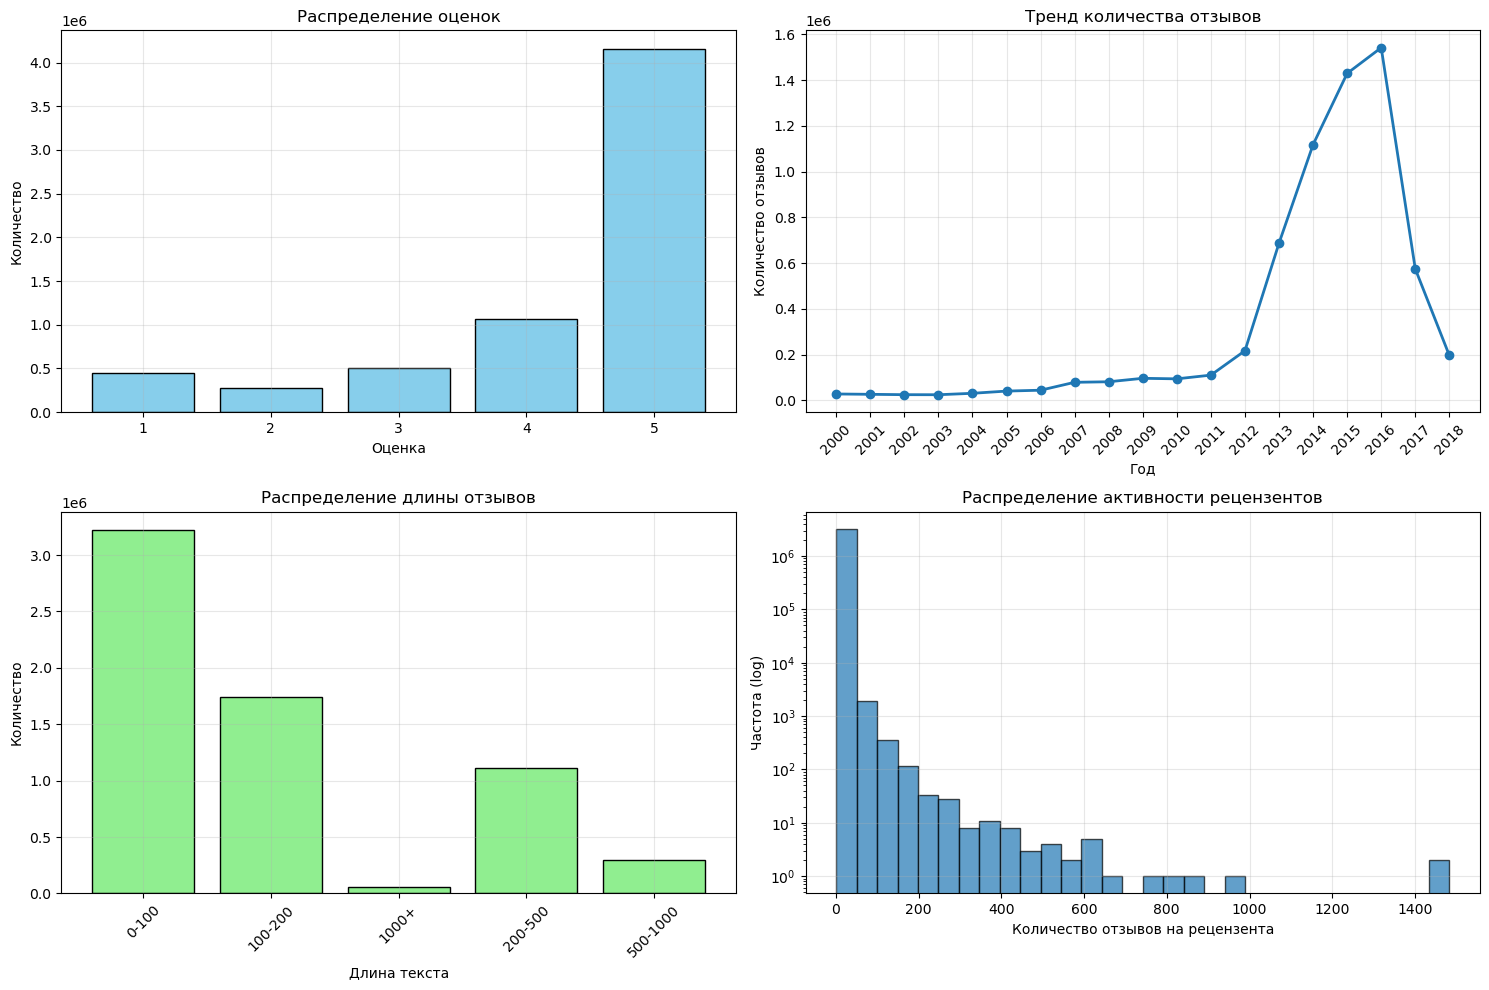

In [13]:
print("=== ИТОГОВЫЙ АНАЛИЗ ДАННЫХ ===")
print("=== КОРРЕЛЯЦИОННЫЙ АНАЛИЗ И ВЫВОДЫ ===\n")

# 1. Создаем числовые признаки для корреляционного анализа
print("1. ПОДГОТОВКА ДАННЫХ ДЛЯ КОРРЕЛЯЦИОННОГО АНАЛИЗА:")
df_correlation = df_final.withColumn("text_length", length("reviewText")) \
                        .withColumn("summary_length", length("summary")) \
                        .withColumn("review_year", year(from_unixtime("unixReviewTime")))

# 2. Корреляционная матрица для числовых признаков
print("\n2. КОРРЕЛЯЦИОННАЯ МАТРИЦА ЧИСЛОВЫХ ПРИЗНАКОВ:")
numeric_columns = ["overall", "text_length", "summary_length", "review_year"]

correlation_matrix = {}
for col1 in numeric_columns:
    correlation_matrix[col1] = {}
    for col2 in numeric_columns:
        corr_value = df_correlation.select(corr(col1, col2)).collect()[0][0]
        correlation_matrix[col1][col2] = corr_value

# Преобразуем в DataFrame Pandas для визуализации (только для тепловой карты)
corr_matrix_pd = pd.DataFrame(correlation_matrix)

# Визуализация тепловой карты корреляций
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_pd, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.3f', linewidths=0.5)
plt.title('Корреляционная матрица числовых признаков')
plt.tight_layout()
plt.show()

# 3. Анализ ключевых корреляций
print("\n3. АНАЛИЗ КЛЮЧЕВЫХ КОРРЕЛЯЦИЙ:")
print("Наиболее значимые корреляции:")
significant_correlations = []

for i, col1 in enumerate(numeric_columns):
    for j, col2 in enumerate(numeric_columns):
        if i < j:  # избегаем дублирования
            corr_val = correlation_matrix[col1][col2]
            if abs(corr_val) > 0.05:  # значимые корреляции
                significant_correlations.append((col1, col2, corr_val))

# Сортируем по абсолютному значению
significant_correlations.sort(key=lambda x: abs(x[2]), reverse=True)

for col1, col2, corr_val in significant_correlations:
    direction = "положительная" if corr_val > 0 else "отрицательная"
    print(f"{col1} ↔ {col2}: {corr_val:.4f} ({direction})")

# 4. Статистика по всем столбцам
print("\n4. ИТОГОВАЯ СТАТИСТИКА ПО ВСЕМ СТОЛБЦАМ:")
total_reviews = df_final.count()
print(f"Общее количество отзывов: {total_reviews:,}")

max_year = df_correlation.agg(max("review_year")).collect()[0][0]
print(f"Период данных: 2000-{max_year} ({max_year - 2000 + 1} лет)")

unique_products = df_final.select("asin").distinct().count()
print(f"Уникальных продуктов: {unique_products:,}")

unique_reviewers = df_final.select("reviewerID").distinct().count()
print(f"Уникальных рецензентов: {unique_reviewers:,}")

# 5. Качество данных - итоговая оценка
print("\n5. ОЦЕНКА КАЧЕСТВА ДАННЫХ:")
quality_metrics = {
    "NULL в ключевых полях": 0,
    "Некорректные ASIN": 0,
    "Некорректные оценки": 0,
    "Некорректные даты": 0,
    "Дубликаты отзывов": 3617
}

print("Проблемы качества данных:")
for metric, count in quality_metrics.items():
    percentage = (count / total_reviews) * 100
    print(f"  {metric}: {count} ({percentage:.4f}%)")

# 6. Визуализация распределения ключевых показателей
print("\n6. ВИЗУАЛИЗАЦИЯ КЛЮЧЕВЫХ ПОКАЗАТЕЛЕЙ:")
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Распределение оценок
rating_dist_collected = df_final.groupBy("overall").agg(sum(lit(1)).alias("count")).orderBy("overall").collect()
ratings = [float(row['overall']) for row in rating_dist_collected]
rating_counts = [row['count'] for row in rating_dist_collected]

axes[0, 0].bar(ratings, rating_counts, color='skyblue', edgecolor='black')
axes[0, 0].set_xlabel("Оценка")
axes[0, 0].set_ylabel("Количество")
axes[0, 0].set_title("Распределение оценок")
axes[0, 0].set_xticks(ratings)
axes[0, 0].grid(True, alpha=0.3)

# Распределение по годам
year_dist_collected = df_correlation.groupBy("review_year").agg(sum(lit(1)).alias("count")).orderBy("review_year").collect()
years = [int(row['review_year']) for row in year_dist_collected]
year_counts = [row['count'] for row in year_dist_collected]

axes[0, 1].plot(years, year_counts, marker='o', linewidth=2)
axes[0, 1].set_xlabel("Год")
axes[0, 1].set_ylabel("Количество отзывов")
axes[0, 1].set_title("Тренд количества отзывов")
axes[0, 1].set_xticks(years)
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(True, alpha=0.3)

# Длина текста отзывов (используем агрегированные данные вместо сэмплирования)
text_length_stats = df_correlation.select(
    when(col("text_length") < 100, "0-100")
    .when(col("text_length").between(100, 200), "100-200")
    .when(col("text_length").between(200, 500), "200-500")
    .when(col("text_length").between(500, 1000), "500-1000")
    .otherwise("1000+").alias("length_category")
).groupBy("length_category").agg(sum(lit(1)).alias("count")).orderBy("length_category").collect()

length_categories = [row['length_category'] for row in text_length_stats]
length_counts = [row['count'] for row in text_length_stats]

axes[1, 0].bar(length_categories, length_counts, color='lightgreen', edgecolor='black')
axes[1, 0].set_xlabel("Длина текста")
axes[1, 0].set_ylabel("Количество")
axes[1, 0].set_title("Распределение длины отзывов")
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(True, alpha=0.3)

# Активность рецензентов (используем агрегированные данные)
reviewer_activity_df = df_final.groupBy("reviewerID").agg(sum(lit(1)).alias("review_count"))

# Сначала смотрим план выполнения
print("План исполнения запроса активности рецензентов")
reviewer_activity_df.explain()


reviewer_activity_collected = reviewer_activity_df.collect()
activity_counts = [row['review_count'] for row in reviewer_activity_collected]

# Создаем гистограмму активности
axes[1, 1].hist(activity_counts, bins=30, edgecolor='black', alpha=0.7, log=True)
axes[1, 1].set_xlabel("Количество отзывов на рецензента")
axes[1, 1].set_ylabel("Частота (log)")
axes[1, 1].set_title("Распределение активности рецензентов")
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### Сохранение данных

In [25]:
output_path_cleaned = "hdfs://hadoop-namenode:9820/data/mattiev_database/movies_lab1_cleaned"

df_final.write \
  .mode("overwrite") \
  .option("compression", "snappy") \
  .parquet(output_path_cleaned)

print(f"Очищенные данные сохранены в: {output_path_cleaned}")

Очищенные данные сохранены в: hdfs://hadoop-namenode:9820/data/mattiev_database/movies_lab1_cleaned


In [26]:
spark.stop()